In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import time

from lightgbm import LGBMClassifier, LGBMRegressor
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (accuracy_score, f1_score, make_scorer,
                             mean_squared_error, r2_score, roc_auc_score,
                             classification_report)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, OrdinalEncoder,
                                   PowerTransformer, StandardScaler)

import warnings
import requests 
from bs4 import BeautifulSoup
import shap

import helper_functions as hf

pd.options.display.float_format = '{:.2f}'.format

import cmd
cli = cmd.Cmd()

# Load Data

In [2]:
## Load in the data for pitchers and batter
relievers = pd.read_csv('../data/cleaned/rookie_relief.csv')

relievers.drop_duplicates(subset=['Season', 'MLBAMID'], inplace=True)

print("Relievers Columns: \n")
cli.columnize(relievers.columns.tolist(), displaywidth=50)

Relievers Columns: 

Season  SD                  WPA_rank        
Name    MD                  WPA/LI_rank     
Team    WAR                 K/BB+_rank      
G       MLBAMID             K-BB%_rank      
IP      decade              SD_rank         
SO      WAR/IP              SD_pct_rank     
ERA     IP/G                Clutch_rank     
ERA-    SD_pct              mean_rookie_rank
FIP     pos                 rookie_rank     
FIP-    league              mlb_rank        
E-F     award_id            mean_mlb_rank   
K/BB+   rookie_of_the_year  key_bbref       
HR/9+   ERA-_rank           awardID         
AVG+    FIP-_rank           yearID          
WHIP+   HR/9+_rank          lgID            
K%+     WHIP+_rank          pointsWon       
BB%+    AVG+_rank           pointsMax       
K-BB%   BB%+_rank           votesFirst      
WPA     MD_rank             unanimous       
WPA/LI  WAR_rank            vote_share      
Clutch  WAR/IP_rank         vote_getter     
SV      IP_rank             WPA/IP

In [3]:
## Load in the data for pitchers and batter
starters = pd.read_csv('../data/cleaned/rookie_starter.csv')

starters.drop_duplicates(subset=['Season', 'MLBAMID'], inplace=True)

print("Starters Columns: \n")
cli.columnize(starters.columns.tolist(), displaywidth=50)

Starters Columns: 

Season  BB%+                K%+_rank        
Name    K-BB%               WPA_rank        
Team    WPA                 WPA/LI_rank     
W       WPA/LI              K/BB+_rank      
L       Clutch              K-BB%_rank      
G       WAR                 Clutch_rank     
GS      MLBAMID             QS_rank         
CG      decade              mean_rookie_rank
ShO     WAR/IP              rookie_rank     
QS      pos                 mlb_rank        
IP      league              mean_mlb_rank   
SO      award_id            key_bbref       
ERA     rookie_of_the_year  awardID         
ERA-    ERA-_rank           yearID          
FIP     FIP-_rank           lgID            
FIP-    HR/9+_rank          pointsWon       
E-F     WHIP+_rank          pointsMax       
K/BB+   AVG+_rank           votesFirst      
HR/9+   BB%+_rank           unanimous       
AVG+    WAR_rank            vote_share      
WHIP+   WAR/IP_rank         vote_getter     
K%+     IP_rank             WPA/IP 

In [4]:
batters = pd.read_csv('../data/cleaned/rookie_batters.csv')

batters.drop_duplicates(subset=['Season', 'MLBAMID'], inplace=True)
print("Batters Columns: \n")
cli.columnize(batters.columns.tolist(), displaywidth=50)

Batters Columns: 

Season  WPA                 Off_rank        
Name    WPA/LI              PA_rank         
Team    Clutch              WPA_rank        
G       WAR                 WPA/LI_rank     
PA      MLBAMID             Clutch_rank     
HR      decade              mean_rookie_rank
R       sb_att              rookie_rank     
RBI     sb_pct              pos             
BB      WAR/G               mean_mlb_rank   
SO      league              mlb_rank        
SB      award_id            key_bbref       
CS      rookie_of_the_year  awardID         
AVG     K%+_rank            yearID          
BB/K    wRC+_rank           lgID            
wOBA    BB%+_rank           pointsWon       
Def     BB/K_rank           pointsMax       
Off     OBP+_rank           votesFirst      
wRC+    SLG+_rank           unanimous       
BB%+    ISO+_rank           vote_share      
K%+     WAR_rank            vote_getter     
OBP+    WAR/G_rank          WPA/G           
SLG+    wOBA_rank         
ISO+    D

## Dimensions of the Data

In [5]:
print(f"Dimensions of Relievers data is {relievers.shape[0]} rows by {relievers.shape[1]} columns")
print(f"Dimensions of Starters data is {starters.shape[0]} rows by {starters.shape[1]} columns")
print(f"Dimensions of Batters data is {batters.shape[0]} rows by {batters.shape[1]} columns")

Dimensions of Relievers data is 707 rows by 68 columns
Dimensions of Starters data is 462 rows by 66 columns
Dimensions of Batters data is 748 rows by 67 columns


In [6]:
roy = pd.read_csv('../data/awards/roy_voting.csv')
roy = roy[roy['yearID'].isin(range(1974, 2024))].copy()
roy = roy[~(roy['yearID'].isin([1994, 2020]))].copy()

In [7]:
print(roy[roy['rookie_of_the_year'] == 1].sort_values('yearID'))

                awardID  yearID lgID   playerID  pointsWon  pointsMax  \
50   Rookie of the Year    1974   AL  hargrmi01         16         24   
51   Rookie of the Year    1974   NL  mcbriba01         16         24   
52   Rookie of the Year    1975   AL   lynnfr01         23         24   
53   Rookie of the Year    1975   NL  montejo01         12         24   
54   Rookie of the Year    1976   AL  fidryma01         22         24   
..                  ...     ...  ...        ...        ...        ...   
147  Rookie of the Year    2021   AL  arozara01        124        150   
148  Rookie of the Year    2022   AL  rodriju01        148        150   
149  Rookie of the Year    2022   NL  harrimi04        134        150   
150  Rookie of the Year    2023   AL  hendegu01        150        150   
151  Rookie of the Year    2023   NL  carroco02        150        150   

     votesFirst  unanimous  rookie_of_the_year  
50           16          0                   1  
51           16          

In [8]:
batters = hf.replace_league(batters)
starters = hf.replace_league(starters)
relievers = hf.replace_league(relievers)

batters = hf.add_roy_column(batters, roy)
relievers = hf.add_roy_column(relievers, roy)
starters = hf.add_roy_column(starters, roy)

batters.loc[batters['Name'] == 'Rafael Furcal', 'rookie_of_the_year'] = 1

## Rookie of the Year Counts

### Relievers

In [9]:
relievers['rookie_of_the_year'].value_counts()

rookie_of_the_year
0.00    697
1.00     10
Name: count, dtype: int64

### Starters

In [10]:
starters['rookie_of_the_year'].value_counts()

rookie_of_the_year
0.00    446
1.00     16
Name: count, dtype: int64

### Batters

In [11]:

batters['rookie_of_the_year'].value_counts()

rookie_of_the_year
0.00    676
1.00     72
Name: count, dtype: int64

# Predicting Vote Getters

- I chose to focus more on the model being able to predict the `vote_getters` in each league. For this I have decided to choose the top 8 vote getters in the NL and AL. This will be decided by the probability of `df['vote_getter'] == 1`from the predictions on the 2024 data.
- I will then use the `vote_getter` information to help with creating a predictive classification model of `rookie_of_the_year`

## Load `fielding` Data

In [12]:
fielding = pd.read_csv('../data/fielding/Fielding.csv')
fielding = fielding[fielding['POS'] != 'P']

outfield = pd.read_csv('../data/fielding/FieldingOFSplit.csv')

outfield_max = outfield.loc[outfield.groupby(['playerID', 'yearID'])['G'].idxmax()]

# Next, merge the `fielding` DataFrame with `outfield_max` to get the new 'POS' value
fielding = pd.merge(fielding, outfield_max[['playerID', 'yearID', 'POS']],
                    on=['playerID', 'yearID'],
                    how='left'
                   )

# Assuming 'POS_x' is the original 'POS' column before merging
mask = (fielding['POS_x'] == 'OF')

# Replace 'POS_x' values where the condition is met with 'POS_y'
fielding.loc[mask, 'POS_x'] = fielding['POS_y']

# Drop the 'POS_y' column as it's no longer needed
fielding.drop(columns='POS_y', inplace=True)

# Rename 'POS_x' back to 'POS' if needed
fielding.rename(columns={'POS_x': 'POS'}, inplace=True)

# Drop any columns that are completely NaN, if that is the intention
# or if there's a specific column you want to check for NaNs
# fielding.dropna(axis='columns', inplace=True) # Use this if you intend to drop all columns with any NaN values
fielding.dropna(subset=['POS'], inplace=True) # This would drop rows where 'POS' became NaN after the replacement

print(fielding.head(10))
print("\n")
# Print the unique values in the 'POS' column
print(fielding['POS'].unique().tolist())


    playerID  yearID  stint teamID lgID POS    G     GS  InnOuts   PO   A  \
0  aaronha01    1954      1    ML1   NL  LF  116 113.00  3093.00  223   5   
1  aaronha01    1955      1    ML1   NL  2B   27  26.00   709.00   86  84   
2  aaronha01    1955      1    ML1   NL  RF  126 125.00  3329.00  254   9   
3  aaronha01    1956      1    ML1   NL  RF  152 152.00  4048.00  316  17   
4  aaronha01    1957      1    ML1   NL  RF  150 150.00  4069.00  346   9   
5  aaronha01    1958      1    ML1   NL  RF  153 153.00  4083.00  305  12   
6  aaronha01    1959      1    ML1   NL  3B    5   5.00   126.00    2  10   
7  aaronha01    1959      1    ML1   NL  RF  152 149.00  3980.00  261  12   
8  aaronha01    1960      1    ML1   NL  2B    2   0.00     6.00    1   0   
9  aaronha01    1960      1    ML1   NL  RF  153 153.00  4129.00  320  13   

      E  DP  PB  WP  SB  CS  ZR  
0  7.00   0 NaN NaN NaN NaN NaN  
1  6.00  23 NaN NaN NaN NaN NaN  
2  9.00   2 NaN NaN NaN NaN NaN  
3 13.00   4 NaN 

### Merge `fielding` data with the `batters`

In [13]:
batters = pd.merge(batters, fielding[['yearID', 'playerID', 'POS']],
              left_on = ['Season', 'key_bbref'],
              right_on = ['yearID', 'playerID'],
              how = 'left')

batters = batters.drop_duplicates(subset=['Season', 'MLBAMID'])

batters.loc[batters['pos'] == 'batter', 'pos'] = batters.loc[batters['pos'] == 'batter', 'POS']

ids_DH = [670541, 660271, 593934, 542994, 606213, 
          119579, 115376, 118370, 119682, 122110, 
          119976, 111795, 119017, 110920]
batters.loc[batters['MLBAMID'].isin(ids_DH), 'pos'] = 'DH'

In [14]:
print(batters.loc[batters['pos'].isna()])

     Season             Name Team    G   PA  HR   R  RBI  BB   SO  ...  \
27     1996  F.P. Santangelo  WSN  152  467   7  54   56  49   61  ...   
94     2000    Rafael Furcal  ATL  131  542   4  87   37  73   80  ...   
374    1987     B.J. Surhoff  MIL  115  445   7  50   68  36   30  ...   
406    1999     Jacque Jones  MIN   95  347   9  54   44  17   63  ...   
558    1998       A.J. Hinch  OAK  120  391   9  34   35  30   89  ...   
597    1982     Tom O'Malley  SFG   92  327   2  26   27  33   39  ...   
936    2022     Riley Greene  DET   93  418   5  46   42  36  120  ...   

     votesFirst  unanimous  vote_share  vote_getter  WPA/G  \
27         0.00       0.00        0.00            0   0.00   
94         0.00       0.00        0.00            0   0.01   
374        0.00       0.00        0.00            0   0.00   
406        0.00       0.00        0.00            0  -0.00   
558        0.00       0.00        0.00            0  -0.01   
597        0.00       0.00        0

In [15]:
pos_data = {'Name': batters.loc[batters['pos'].isna(), 'Name'].tolist(),
            'Season': batters.loc[batters['pos'].isna(), 'Season'].tolist(),
            'pos': ['CF', 'SS', 'C', 'CF','CF', '3B', 'C']}
pos_data = pd.DataFrame(pos_data)

batters.loc[batters['pos'].isna(), 'pos'] = pos_data['pos'].values

In [16]:
relievers = hf.convert_to_cat(data = relievers)
starters = hf.convert_to_cat(data = starters)
batters = hf.convert_to_cat(data = batters)

## Predictors and Predicted

## Vote Getter Model

### Relievers

In [17]:
relievers = hf.add_interactions('ERA-', 'FIP-', data=relievers)
relievers = hf.add_interactions('IP', 'K/BB+', data=relievers)
relievers = hf.add_interactions('IP', 'K%+', data=relievers)
relievers = hf.add_interactions('IP', 'ERA-', data=relievers)
relievers = hf.add_interactions('IP', 'FIP-', data=relievers)
relievers = hf.add_interactions('K%+', 'BB%+', data=relievers)
relievers = hf.add_interactions('HR/9+', 'BB%+', data=relievers)
relievers = hf.add_interactions('K%+', 'ERA-', data=relievers)
relievers = hf.add_interactions('K%+', 'HR/9+', data=relievers)
relievers = hf.add_interactions('WHIP+', 'ERA-', data=relievers)
relievers = hf.add_interactions('WHIP+', 'FIP-', data=relievers)
relievers = hf.add_interactions('K-BB%', 'ERA-', data=relievers)
relievers = hf.add_interactions('K-BB%', 'FIP-', data=relievers)
relievers = hf.add_interactions('WHIP+', 'HR/9+', data=relievers)
relievers = hf.add_interactions('SD', 'MD', data=relievers)
relievers = hf.add_interactions('SD', 'SD_pct', data=relievers)

relievers = hf.add_interactions('ERA-_int_FIP-', 'WAR', data=relievers)
relievers = hf.add_interactions('ERA-_int_FIP-', 'WPA', data=relievers)
relievers = hf.add_interactions('ERA-_int_FIP-', 'IP', data=relievers)
relievers = hf.add_interactions('ERA-_int_FIP-', 'SD_int_MD', data=relievers)
relievers = hf.add_interactions('SD_int_MD', 'SD_pct', data=relievers)

X_train is 494 rows by 37 columns 

X_test is 213 rows by 37 columns 

Number of positive values = 78 

Number of negative values = 629 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[136]	cv_agg's train binary_logloss: 0.149405 + 0.00231802	cv_agg's train f1_score: 0.800186 + 0.00980045	cv_agg's valid binary_logloss: 0.225445 + 0.025749	cv_agg's valid f1_score: 0.596747 + 0.0834367
F1-Score: 0.5967472527472528
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[196]	cv_agg's train binary_logloss: 0.214353 + 0.00993596	cv_agg's train f1_score: 0.705722 + 0.0195427	cv_agg's valid binary_logloss: 0.255161 + 0.0212413	cv_agg's valid f1_score: 0.592921 + 0.0729
F1-Score: 0.5929209998175515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[54]	cv_agg's train binary_logloss: 0.0994791 + 0.00395671	cv_agg's train f1_score: 

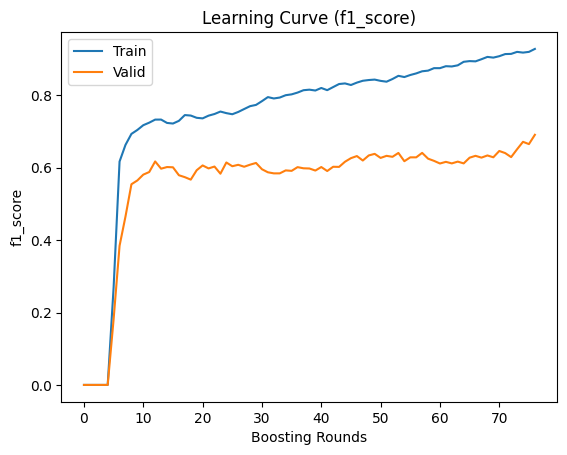


 Total time to Hypertune Model = 6.297837567329407 minutes


In [18]:
space = {
    'num_boost_round': hp.quniform('num_boost_round', 75, 250, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'num_leaves': hp.quniform('num_leaves', 3, 15, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 5, 30, 1),
    'lambda_l1': hp.loguniform('lambda_l1', np.log(0.01), np.log(5)),
    'lambda_l2': hp.loguniform('lambda_l2', np.log(0.01), np.log(5)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 0.9),
    'bagging_freq': hp.quniform('bagging_freq', 1, 8, 1),
    'verbose': int(-1)
}

int_cols = relievers.filter(regex="_int_").columns.tolist()

predictors =  int_cols + ['ERA-', 'FIP-', 'K/BB+',
                          'AVG+', 'WHIP+', 'BB%+', 'K-BB%', 
                          'WPA/LI', 'WPA/IP', 'WAR/IP', 
                          'WAR', 'SD', 'SD_pct',
                          'decade', 'pos', 'league']

rel_vm = hf.model_and_tune(data=relievers, target_var='vote_getter', predictors=predictors, stop_rounds=100,
                    space=space, stratify_col='vote_getter', max_evals=250, test_size=0.3)

### Starters

In [19]:
starters = hf.add_interactions('ERA-', 'FIP-', data=starters)
starters = hf.add_interactions('ERA-', 'BB%+', data=starters)
starters = hf.add_interactions('ERA-', 'HR/9+', data=starters)
starters = hf.add_interactions('IP', 'K/BB+', data=starters)
starters = hf.add_interactions('IP', 'K%+', data=starters)
starters = hf.add_interactions('IP', 'ERA-', data=starters)
starters = hf.add_interactions('IP', 'FIP-', data=starters)
starters = hf.add_interactions('K%+', 'BB%+', data=starters)
starters = hf.add_interactions('K%+', 'HR/9+', data=starters)
starters = hf.add_interactions('HR/9+', 'BB%+', data=starters)
starters = hf.add_interactions('K%+', 'ERA-', data=starters)
starters = hf.add_interactions('WHIP+', 'ERA-', data=starters)
starters = hf.add_interactions('WHIP+', 'FIP-', data=starters)
starters = hf.add_interactions('WHIP+', 'HR/9+', data=starters)
starters = hf.add_interactions('K-BB%', 'ERA-', data=starters)
starters = hf.add_interactions('K-BB%', 'FIP-', data=starters)

starters = hf.add_interactions('ERA-_int_FIP-', 'WAR', data=starters)
starters = hf.add_interactions('ERA-_int_FIP-', 'WPA', data=starters)

X_train is 323 rows by 32 columns 

X_test is 139 rows by 32 columns 

Number of positive values = 173 

Number of negative values = 289 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[136]	cv_agg's train binary_logloss: 0.329787 + 0.0138612	cv_agg's train f1_score: 0.853359 + 0.020112	cv_agg's valid binary_logloss: 0.454307 + 0.0679839	cv_agg's valid f1_score: 0.743774 + 0.0963876
F1-Score: 0.7437741527349059
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[196]	cv_agg's train binary_logloss: 0.412856 + 0.0172582	cv_agg's train f1_score: 0.797267 + 0.0199924	cv_agg's valid binary_logloss: 0.48166 + 0.0436036	cv_agg's valid f1_score: 0.730355 + 0.0790638
F1-Score: 0.7303546733655591
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	cv_agg's train binary_logloss: 0.334627 + 0.0169811	cv_agg's train f1_score: 0.

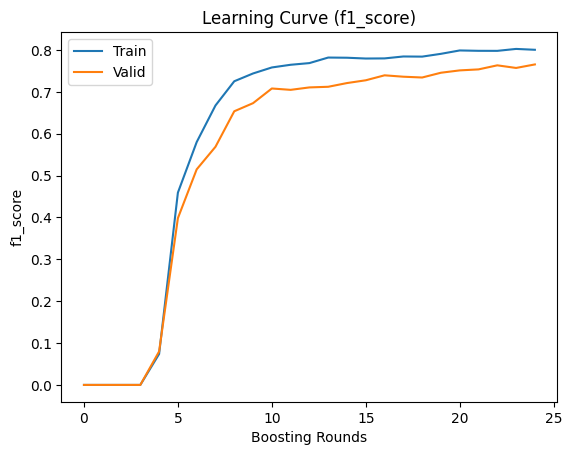


 Total time to Hypertune Model = 5.619462299346924 minutes


In [20]:
int_cols = starters.filter(regex="_int_").columns.tolist()
predictors = int_cols + ['ERA-', 'FIP-', 'K/BB+',
                         'AVG+', 'WHIP+', 'K%+', 'K-BB%', 
                         'WPA/LI', 'WPA/IP', 'WAR/IP', 
                         'WAR',
                         'decade', 'pos', 'league']

st_vm = hf.model_and_tune(data=starters, target_var='vote_getter', predictors=predictors, stop_rounds=100,
                    space=space, stratify_col='vote_getter', max_evals=250)

### Batters

In [21]:
batters = hf.add_interactions('Def', 'Off', data=batters)
batters = hf.add_interactions('wOBA', 'BB/K', data=batters)
batters = hf.add_interactions('PA', 'WAR', data=batters)
batters = hf.add_interactions('PA', 'wRC+', data=batters)
batters = hf.add_interactions('PA', 'K%+', data=batters)
batters = hf.add_interactions('PA', 'BB%+', data=batters)
batters = hf.add_interactions('PA', 'OBP+', data=batters)
batters = hf.add_interactions('wRC+', 'WAR', data=batters)
batters = hf.add_interactions('wOBA', 'WAR', data=batters)
batters = hf.add_interactions('OBP+', 'SLG+', data=batters)
batters = hf.add_interactions('OBP+', 'ISO+', data=batters)
batters = hf.add_interactions('wRC+', 'WPA', data=batters)
batters = hf.add_interactions('wOBA', 'WPA', data=batters)
batters = hf.add_interactions('BB%+', 'K%+', data=batters)

batters = hf.add_interactions('Def_int_Off', 'WPA', data=batters)
batters = hf.add_interactions('Def_int_Off', 'WAR', data=batters)

X_train is 523 rows by 30 columns 

X_test is 225 rows by 30 columns 

Number of positive values = 398 

Number of negative values = 350 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[136]	cv_agg's train binary_logloss: 0.332609 + 0.012659	cv_agg's train f1_score: 0.898124 + 0.0082343	cv_agg's valid binary_logloss: 0.433604 + 0.0508738	cv_agg's valid f1_score: 0.817781 + 0.0451841
F1-Score: 0.8177808753730073
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[196]	cv_agg's train binary_logloss: 0.41544 + 0.0128927	cv_agg's train f1_score: 0.852268 + 0.00673869	cv_agg's valid binary_logloss: 0.460512 + 0.0468211	cv_agg's valid f1_score: 0.814268 + 0.0451755
F1-Score: 0.8142678324954602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[58]	cv_agg's train binary_logloss: 0.221596 + 0.00827227	cv_agg's train f1_score: 

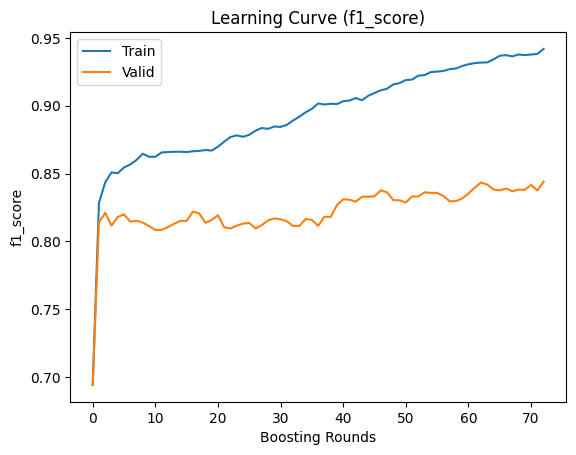


 Total time to Hypertune Model = 6.5409778475761415 minutes


In [22]:
int_cols = batters.filter(regex='_int_').columns.tolist()

predictors = int_cols + ['BB/K', 'wOBA', 'wRC+', 
                        'OBP+', 'SLG+',
                         'ISO+', 'WPA/G', 'WPA/LI', 'WAR/G', 
                         'Off', 'WAR', 
                         'decade', 'league', 'pos']
bat_vm = hf.model_and_tune(data=batters, target_var='vote_getter', predictors=predictors, stop_rounds=100,
                    space=space, stratify_col='vote_getter', max_evals=250)

### Evaluate Model Performance

- Evaluate the model based on the `lgb_test` Dataset

In [23]:
rel_eval = hf.eval_model(model_tuple=rel_vm)
st_eval = hf.eval_model(model_tuple=st_vm)
bat_eval = hf.eval_model(model_tuple=bat_vm)

### Confusion Matrix of Model Validation

In [24]:
rel_cm = hf.conf_mat_model(rel_eval, output_dict=True)
st_cm = hf.conf_mat_model(st_eval, output_dict=True)
bat_cm = hf.conf_mat_model(bat_eval, output_dict=True)

## Feature Importance

In [25]:
rel_feat_imp = hf.feat_imp_eval(rel_eval)
st_feat_imp = hf.feat_imp_eval(st_eval)
bat_feat_imp = hf.feat_imp_eval(bat_eval)

### SHAP Values for Feature Importance

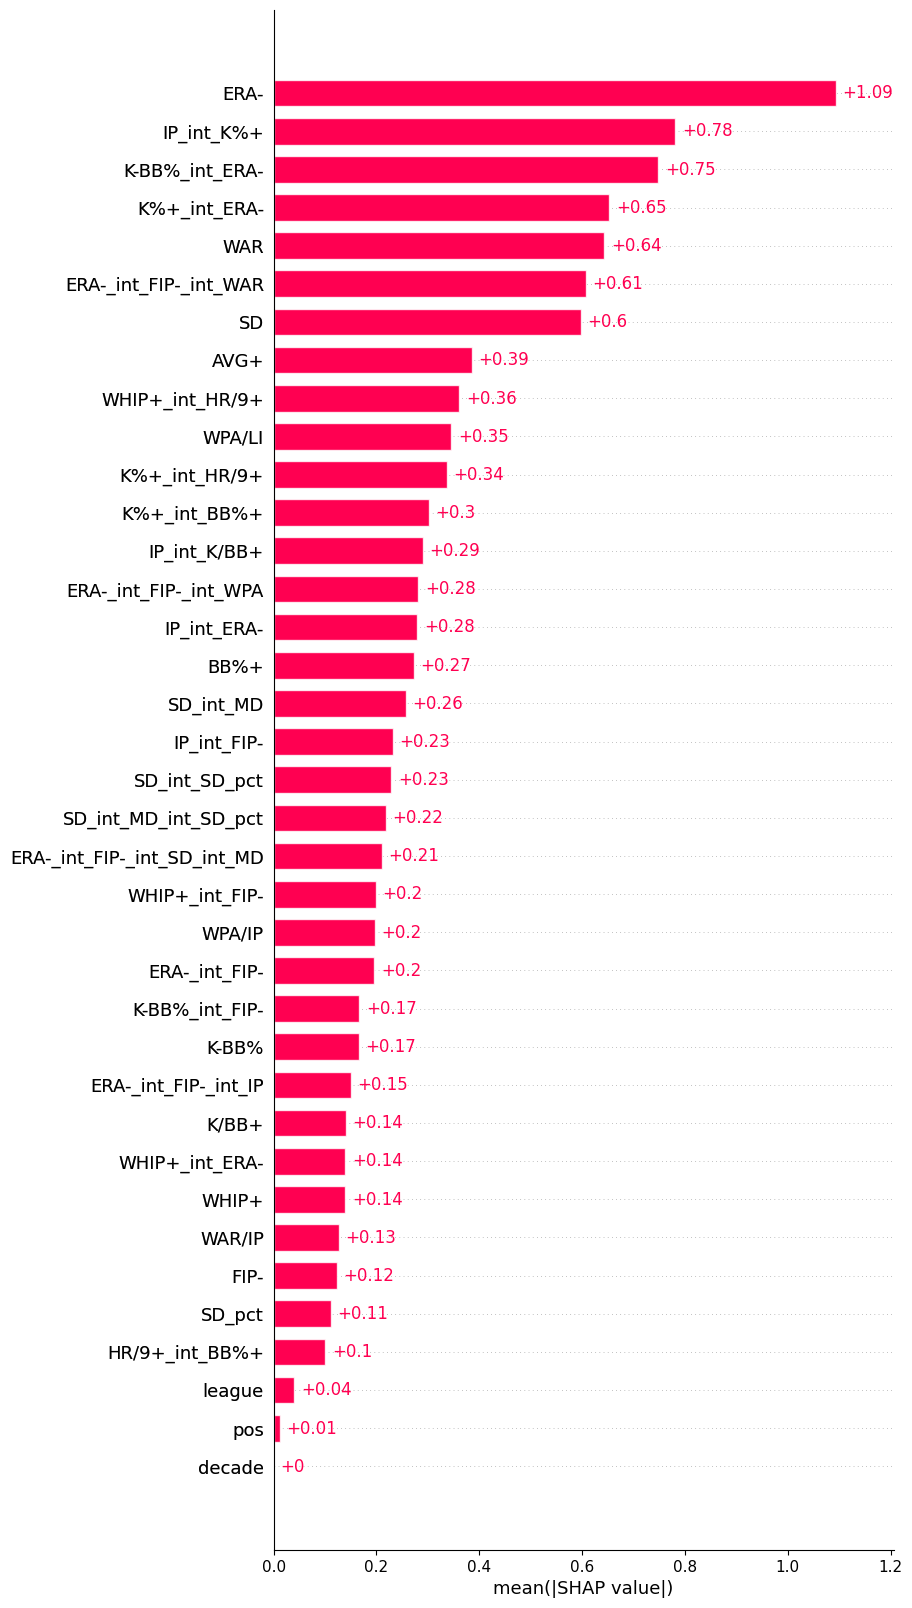

Total Time to Generate Plot: 0.0038495699564615885 minutes


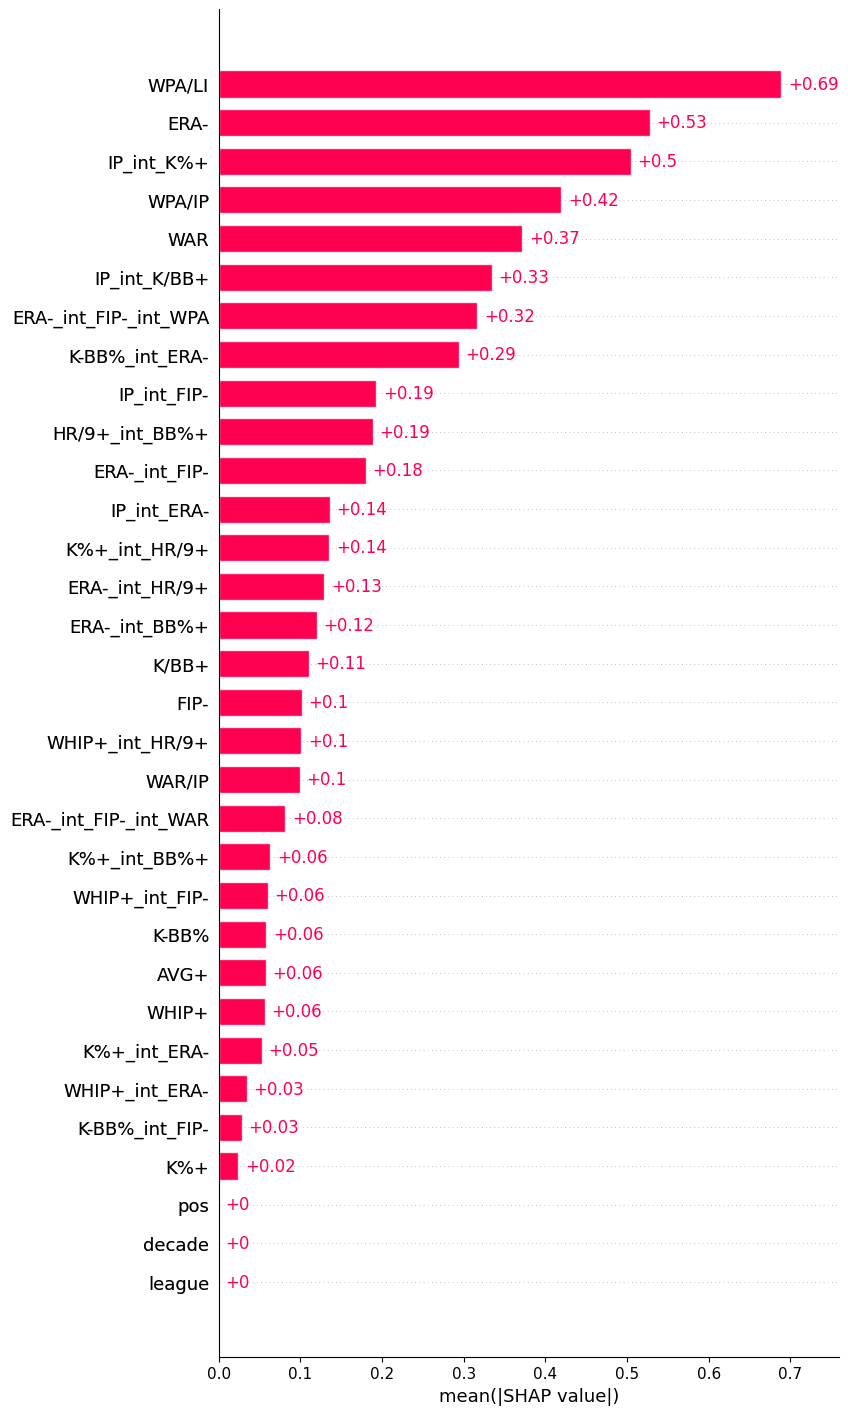

Total Time to Generate Plot: 0.0027460654576619468 minutes


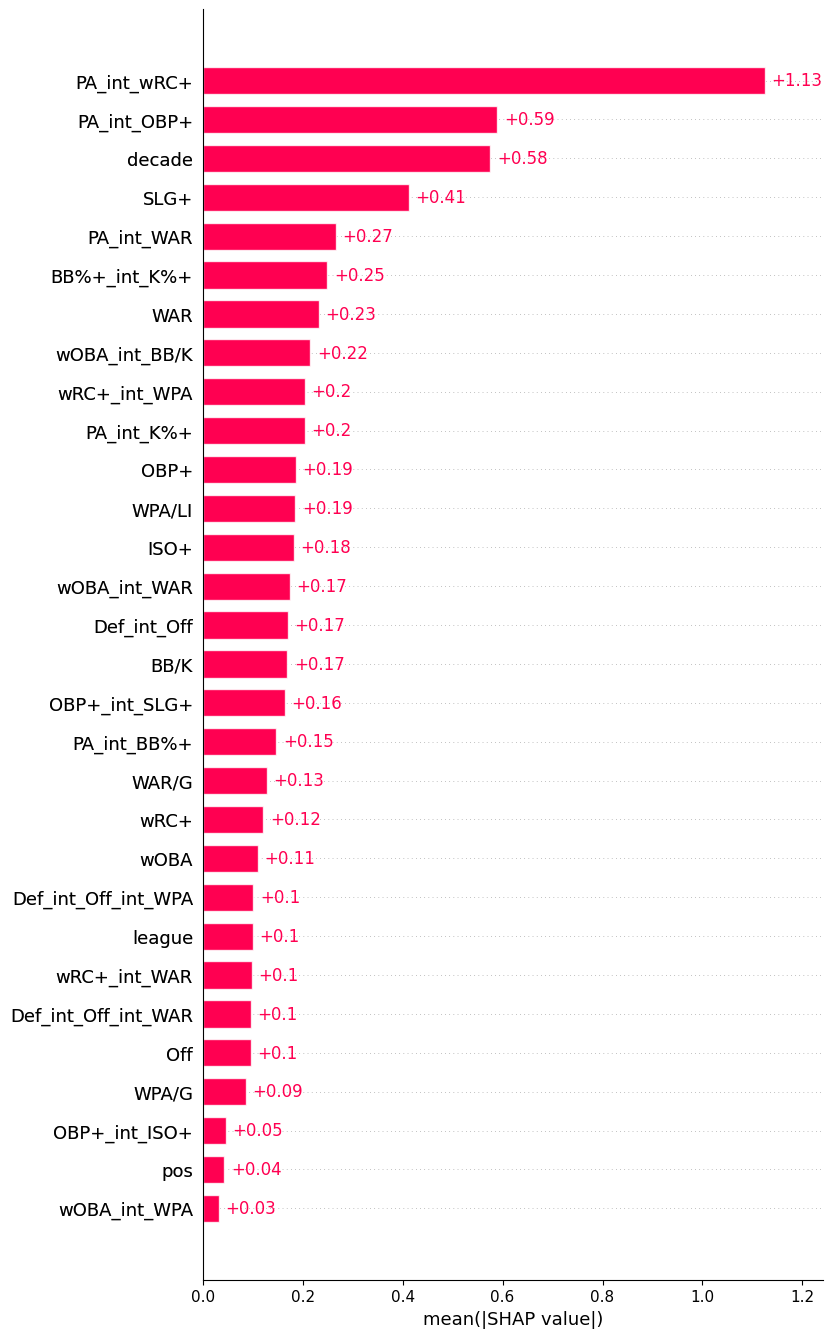

Total Time to Generate Plot: 0.0028747002283732097 minutes


In [26]:
rel_shap_rank = hf.plot_shap_ranks(rel_eval, rel_feat_imp)
st_shap_rank = hf.plot_shap_ranks(st_eval, st_feat_imp)
bat_shap_rank = hf.plot_shap_ranks(bat_eval, bat_feat_imp)

In [27]:
rel_shap_rank

,Feature,mean_shap_value,Importance,imp_pct,imp_Rank,shap_Rank,avg_Rank
0,IP_int_K%+,0.78,632.31,11.30,3.00,2.00,2.45
1,ERA-,1.09,293.01,5.24,6.00,1.00,3.25
2,K%+_int_ERA-,0.65,314.42,5.62,5.00,4.00,4.45
3,SD,0.60,651.13,11.64,2.00,7.00,4.75
4,K-BB%_int_ERA-,0.75,194.84,3.48,9.00,3.00,5.70
5,WAR,0.64,204.11,3.65,8.00,5.00,6.35
6,ERA-_int_FIP-_int_WAR,0.61,207.06,3.70,7.00,6.00,6.45
7,AVG+,0.39,114.08,2.04,14.00,8.00,10.70
8,SD_int_SD_pct,0.23,689.56,12.32,1.00,19.00,10.90
9,WHIP+_int_HR/9+,0.36,98.66,1.76,17.00,9.00,12.60


In [28]:
st_shap_rank

,Feature,mean_shap_value,Importance,imp_pct,imp_Rank,shap_Rank,avg_Rank
0,WPA/LI,0.69,968.33,20.22,1.00,1.00,1.00
1,ERA-,0.53,323.94,6.76,3.00,2.00,2.45
2,IP_int_K%+,0.50,489.51,10.22,2.00,3.00,2.55
3,WPA/IP,0.42,277.03,5.78,5.00,4.00,4.45
4,ERA-_int_FIP-_int_WPA,0.32,286.67,5.98,4.00,7.00,5.65
5,WAR,0.37,216.47,4.52,7.00,5.00,5.90
6,IP_int_K/BB+,0.33,274.62,5.73,6.00,6.00,6.00
7,K-BB%_int_ERA-,0.29,206.84,4.32,8.00,8.00,8.00
8,IP_int_FIP-,0.19,200.00,4.18,9.00,9.00,9.00
9,HR/9+_int_BB%+,0.19,112.94,2.36,13.00,10.00,11.35


In [29]:
bat_shap_rank

,Feature,mean_shap_value,Importance,imp_pct,imp_Rank,shap_Rank,avg_Rank
0,PA_int_wRC+,1.13,1963.92,36.56,1.00,1.00,1.00
1,PA_int_OBP+,0.59,341.03,6.35,2.00,2.00,2.00
2,PA_int_WAR,0.27,187.25,3.49,3.00,5.00,4.10
3,decade,0.58,160.74,2.99,7.00,3.00,4.80
4,SLG+,0.41,162.39,3.02,6.00,4.00,4.90
5,WAR,0.23,146.54,2.73,10.00,7.00,8.35
6,WPA/LI,0.19,182.02,3.39,4.00,12.00,8.40
7,PA_int_K%+,0.20,153.68,2.86,8.00,10.00,9.10
8,BB%+_int_K%+,0.25,141.97,2.64,13.00,6.00,9.15
9,wOBA_int_BB/K,0.22,144.13,2.68,12.00,8.00,9.80


### Update the Model Parameters

In [30]:
rel_eval_x = hf.evaluate_predictors(rank_df=rel_shap_rank, model_tuple=rel_vm, data=relievers, 
                                    stratify_col='vote_getter', target_var='vote_getter', 
                                    conf_mat_func=hf.conf_mat_model, 
                                    min_preds=17, max_preds=35)

In [31]:
num_to_remove = rel_eval_x['num_preds_to_remove']
best_rel_preds = rel_shap_rank['Feature'][:-num_to_remove]

up_rel_eval = hf.update_mod_eval(model_tuple=rel_vm, best_predictors = best_rel_preds, data=relievers,
                stratify_col='vote_getter', target_var='vote_getter')
up_conf_mat_rel = hf.conf_mat_model(up_rel_eval, output_dict=False)

In [32]:
print(up_conf_mat_rel)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       190
           1       0.56      0.61      0.58        23

    accuracy                           0.91       213
   macro avg       0.76      0.78      0.77       213
weighted avg       0.91      0.91      0.91       213



In [36]:
st_eval_x = hf.evaluate_predictors(rank_df=st_shap_rank, model_tuple=st_vm, data=starters, 
                                   stratify_col='vote_getter', target_var='vote_getter', 
                                   conf_mat_func=hf.conf_mat_model, 
                                   min_preds=12, max_preds=30)

In [37]:
num_to_remove = st_eval_x['num_preds_to_remove']
best_st_preds = st_shap_rank['Feature'][:-num_to_remove]

up_st_eval = hf.update_mod_eval(model_tuple=st_vm, best_predictors = best_st_preds, data=starters,
                                stratify_col='vote_getter', target_var='vote_getter')
up_conf_mat_st = hf.conf_mat_model(up_st_eval, output_dict=False)

In [38]:
print(up_conf_mat_st)

              precision    recall  f1-score   support

           0       0.82      0.79      0.81        87
           1       0.67      0.71      0.69        52

    accuracy                           0.76       139
   macro avg       0.75      0.75      0.75       139
weighted avg       0.77      0.76      0.76       139



In [40]:
bat_eval_x = hf.evaluate_predictors(rank_df=bat_shap_rank, model_tuple=bat_vm, data=batters, 
                                    stratify_col='vote_getter', target_var='vote_getter', conf_mat_func=hf.conf_mat_model, 
                                    min_preds=9, max_preds=25)

In [41]:
num_to_remove = bat_eval_x['num_preds_to_remove']
best_bat_preds = bat_shap_rank['Feature'][:-num_to_remove]

up_bat_eval = hf.update_mod_eval(model_tuple=bat_vm, best_predictors = best_bat_preds, 
                              data=batters, stratify_col='vote_getter', target_var='vote_getter')
up_conf_mat_bat = hf.conf_mat_model(up_bat_eval, output_dict=False)

In [42]:
print(up_conf_mat_bat)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       105
           1       0.83      0.82      0.83       120

    accuracy                           0.82       225
   macro avg       0.82      0.82      0.82       225
weighted avg       0.82      0.82      0.82       225



In [43]:
up_rel_feat_imp = hf.feat_imp_eval(up_rel_eval)
up_st_feat_imp = hf.feat_imp_eval(up_st_eval)
up_bat_feat_imp = hf.feat_imp_eval(up_bat_eval)

In [44]:
print(up_rel_feat_imp)

                  Feature  Importance  imp_pct
3                      SD      769.81    13.79
8           SD_int_SD_pct      735.56    13.17
0              IP_int_K%+      607.75    10.88
15          ERA-_int_FIP-      403.69     7.23
1                    ERA-      401.17     7.18
2            K%+_int_ERA-      327.01     5.86
4          K-BB%_int_ERA-      289.52     5.18
10           IP_int_K/BB+      285.58     5.11
12                   BB%+      273.37     4.90
5                     WAR      259.92     4.65
6   ERA-_int_FIP-_int_WAR      254.25     4.55
14            IP_int_FIP-      251.27     4.50
7                    AVG+      181.44     3.25
16  ERA-_int_FIP-_int_WPA      160.20     2.87
11          K%+_int_HR/9+      153.72     2.75
9         WHIP+_int_HR/9+      151.67     2.72
13                 WPA/LI       78.10     1.40


In [45]:
print(up_st_feat_imp)

                 Feature  Importance  imp_pct
0                 WPA/LI     1200.09    27.71
2             IP_int_K%+      668.10    15.43
6           IP_int_K/BB+      560.84    12.95
5                    WAR      486.79    11.24
1                   ERA-      391.22     9.03
3                 WPA/IP      388.38     8.97
7         K-BB%_int_ERA-      375.17     8.66
4  ERA-_int_FIP-_int_WPA      260.10     6.01


In [46]:
print(up_bat_feat_imp)

          Feature  Importance  imp_pct
0     PA_int_wRC+     2024.84    39.06
1     PA_int_OBP+      411.38     7.93
9   wOBA_int_BB/K      410.85     7.92
5             WAR      401.36     7.74
6          WPA/LI      353.28     6.81
8    BB%+_int_K%+      329.07     6.35
10           OBP+      304.45     5.87
4            SLG+      275.51     5.31
7      PA_int_K%+      261.34     5.04
2      PA_int_WAR      254.42     4.91
3          decade      158.08     3.05


## Make Predictions

- Make Predictions on the 2024 rookies in each league who are predicted to receive votes

In [47]:
relievers_24 = pd.read_csv('../data/cleaned/rookie_relief_24.csv')
starters_24 = pd.read_csv('../data/cleaned/rookie_starter_24.csv')
batters_24 = pd.read_csv('../data/cleaned/rookie_batters_24.csv')

relievers_24.drop_duplicates(subset=['Season', 'MLBAMID'], inplace=True)
starters_24.drop_duplicates(subset=['Season', 'MLBAMID'], inplace=True)
batters_24.drop_duplicates(subset=['Season', 'MLBAMID'], inplace=True)

In [48]:
relievers_24 = hf.convert_to_cat(data = relievers_24)
starters_24 = hf.convert_to_cat(data = starters_24)
batters_24 = hf.convert_to_cat(data = batters_24)

### Webscrape MLB.com for Positions

- Had to do this because batters from 2024 are missing detailed fielding information as the Lahman database fielding info I used is only through 2023 and does not include 2024.

In [49]:
batters_24['pos'] = batters_24['pos'].astype('str')

# Apply the function to each MLBAMID in the DataFrame
batters_24['Position'] = batters_24['MLBAMID'].apply(hf.get_player_position)

batters_24.loc[batters_24['pos'] == 'batter', 'pos'] = batters_24.loc[batters_24['pos'] == 'batter', 'Position']
batters_24 = batters_24.drop_duplicates(subset=['Season', 'MLBAMID'])

In [50]:
relievers_24 = hf.add_interactions('ERA-', 'FIP-', data=relievers_24)
relievers_24 = hf.add_interactions('IP', 'K/BB+', data=relievers_24)
relievers_24 = hf.add_interactions('IP', 'K%+', data=relievers_24)
relievers_24 = hf.add_interactions('IP', 'ERA-', data=relievers_24)
relievers_24 = hf.add_interactions('IP', 'FIP-', data=relievers_24)
relievers_24 = hf.add_interactions('K%+', 'BB%+', data=relievers_24)
relievers_24 = hf.add_interactions('HR/9+', 'BB%+', data=relievers_24)
relievers_24 = hf.add_interactions('K%+', 'ERA-', data=relievers_24)
relievers_24 = hf.add_interactions('K%+', 'HR/9+', data=relievers_24)
relievers_24 = hf.add_interactions('WHIP+', 'ERA-', data=relievers_24)
relievers_24 = hf.add_interactions('WHIP+', 'FIP-', data=relievers_24)
relievers_24 = hf.add_interactions('K-BB%', 'ERA-', data=relievers_24)
relievers_24 = hf.add_interactions('K-BB%', 'FIP-', data=relievers_24)
relievers_24 = hf.add_interactions('WHIP+', 'HR/9+', data=relievers_24)
relievers_24 = hf.add_interactions('SD', 'MD', data=relievers_24)
relievers_24 = hf.add_interactions('SD', 'SD_pct', data=relievers_24)

relievers_24 = hf.add_interactions('ERA-_int_FIP-', 'WAR', data=relievers_24)
relievers_24 = hf.add_interactions('ERA-_int_FIP-', 'WPA', data=relievers_24)
relievers_24 = hf.add_interactions('ERA-_int_FIP-', 'IP', data=relievers_24)
relievers_24 = hf.add_interactions('ERA-_int_FIP-', 'SD_int_MD', data=relievers_24)
relievers_24 = hf.add_interactions('SD_int_MD', 'SD_pct', data=relievers_24)

In [51]:
starters_24 = hf.add_interactions('ERA-', 'FIP-', data=starters_24)
starters_24 = hf.add_interactions('ERA-', 'BB%+', data=starters_24)
starters_24 = hf.add_interactions('ERA-', 'HR/9+', data=starters_24)
starters_24 = hf.add_interactions('IP', 'K/BB+', data=starters_24)
starters_24 = hf.add_interactions('IP', 'K%+', data=starters_24)
starters_24 = hf.add_interactions('IP', 'ERA-', data=starters_24)
starters_24 = hf.add_interactions('IP', 'FIP-', data=starters_24)
starters_24 = hf.add_interactions('K%+', 'BB%+', data=starters_24)
starters_24 = hf.add_interactions('K%+', 'HR/9+', data=starters_24)
starters_24 = hf.add_interactions('HR/9+', 'BB%+', data=starters_24)
starters_24 = hf.add_interactions('K%+', 'ERA-', data=starters_24)
starters_24 = hf.add_interactions('WHIP+', 'ERA-', data=starters_24)
starters_24 = hf.add_interactions('WHIP+', 'FIP-', data=starters_24)
starters_24 = hf.add_interactions('WHIP+', 'HR/9+', data=starters_24)
starters_24 = hf.add_interactions('K-BB%', 'ERA-', data=starters_24)
starters_24 = hf.add_interactions('K-BB%', 'FIP-', data=starters_24)

starters_24 = hf.add_interactions('ERA-_int_FIP-', 'WAR', data=starters_24)
starters_24 = hf.add_interactions('ERA-_int_FIP-', 'WPA', data=starters_24)

In [52]:
batters_24 = hf.add_interactions('Def', 'Off', data=batters_24)
batters_24 = hf.add_interactions('wOBA', 'BB/K', data=batters_24)
batters_24 = hf.add_interactions('PA', 'WAR', data=batters_24)
batters_24 = hf.add_interactions('PA', 'wRC+', data=batters_24)
batters_24 = hf.add_interactions('PA', 'K%+', data=batters_24)
batters_24 = hf.add_interactions('PA', 'BB%+', data=batters_24)
batters_24 = hf.add_interactions('PA', 'OBP+', data=batters_24)
batters_24 = hf.add_interactions('wRC+', 'WAR', data=batters_24)
batters_24 = hf.add_interactions('wOBA', 'WAR', data=batters_24)
batters_24 = hf.add_interactions('OBP+', 'SLG+', data=batters_24)
batters_24 = hf.add_interactions('OBP+', 'ISO+', data=batters_24)
batters_24 = hf.add_interactions('wRC+', 'WPA', data=batters_24)
batters_24 = hf.add_interactions('wOBA', 'WPA', data=batters_24)
batters_24 = hf.add_interactions('BB%+', 'K%+', data=batters_24)

batters_24 = hf.add_interactions('Def_int_Off', 'WPA', data=batters_24)
batters_24 = hf.add_interactions('Def_int_Off', 'WAR', data=batters_24)


In [53]:
batters_24 = hf.convert_to_cat(batters_24)
relievers_24 = hf.convert_to_cat(relievers_24)
starters_24 = hf.convert_to_cat(starters_24)

In [54]:
rel_preds = hf.make_preds(data=relievers_24, predictors=best_rel_preds,
                       eval_tuple=up_rel_eval, target='vote_getter')
st_preds = hf.make_preds(data=starters_24, predictors=best_st_preds,
                       eval_tuple=up_st_eval, target='vote_getter')
bat_preds = hf.make_preds(data=batters_24, predictors=best_bat_preds,
                       eval_tuple=up_bat_eval, target='vote_getter')

In [55]:
combine_cols = ['Name', 'Team', 'league', 'pos', 'vote_getter']
# Concatenate the dataframes
preds_df = pd.concat([rel_preds[combine_cols].copy(), st_preds[combine_cols].copy(), bat_preds[combine_cols].copy()])
# Sort by 'vote_getter'
preds_df = preds_df.sort_values('vote_getter', ascending=False)

# Save the dataframe to CSV
preds_df.to_csv('../data/predictions/vote_preds.csv', index=False)

# Get the top 8 rows for each 'league'
top_vote_getters = preds_df.groupby('league', observed=False).head(8)
print(top_vote_getters)

                       Name Team league      pos  vote_getter
1           Jackson Merrill  SDP     NL       CF         0.98
3              Austin Wells  NYY     AL        C         0.97
0           Jackson Chourio  MIL     NL       RF         0.97
4             Michael Busch  CHC     NL       1B         0.96
1             Shota Imanaga  CHC     NL  starter         0.95
0               Paul Skenes  PIT     NL  starter         0.93
5                Joey Ortiz  MIL     NL       3B         0.90
7                Masyn Winn  STL     NL       SS         0.87
3                  Luis Gil  NYY     AL  starter         0.86
21               Cade Smith  CLE     AL   relief         0.82
15          Justin Martinez  ARI     NL   relief         0.80
8             Colton Cowser  BAL     AL       LF         0.79
6              Wilyer Abreu  BOS     AL       RF         0.71
2           Spencer Horwitz  TOR     AL       2B         0.63
8   Simeon Woods Richardson  MIN     AL  starter         0.50
10      

In [56]:
batters_24 = hf.round_vote_getters(top_vote_getters, batters_24)
relievers_24 = hf.round_vote_getters(top_vote_getters, relievers_24)
starters_24 = hf.round_vote_getters(top_vote_getters, starters_24)

## Rookie of the Year Model

### Relievers

#### Deciding Between Features

In [57]:
relievers = hf.convert_to_cat(data=relievers, cols=['league', 'pos', 'decade', 'vote_getter'])
starters = hf.convert_to_cat(data=starters, cols=['league', 'pos', 'decade', 'vote_getter'])
batters = hf.convert_to_cat(data=batters, cols=['league', 'pos', 'decade', 'vote_getter'])

X_train is 494 rows by 37 columns 

X_test is 213 rows by 37 columns 

Number of positive values = 10 

Number of negative values = 697 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[40]	cv_agg's train binary_logloss: 0.0383346 + 0.00635503	cv_agg's train f1_score: 0.38 + 0.1991	cv_agg's valid binary_logloss: 0.0625391 + 0.0199498	cv_agg's valid f1_score: 0.133333 + 0.266667
F1-Score: 0.13333333333333333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[40]	cv_agg's train binary_logloss: 0.0430345 + 0.00314626	cv_agg's train f1_score: 0 + 0	cv_agg's valid binary_logloss: 0.0612652 + 0.0112806	cv_agg's valid f1_score: 0 + 0
F1-Score: 0.0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	cv_agg's train binary_logloss: 0.0540543 + 0.0169488	cv_agg's train f1_score: 0.545299 + 0.110041	cv_agg's valid binary_logloss: 0.0815481 +

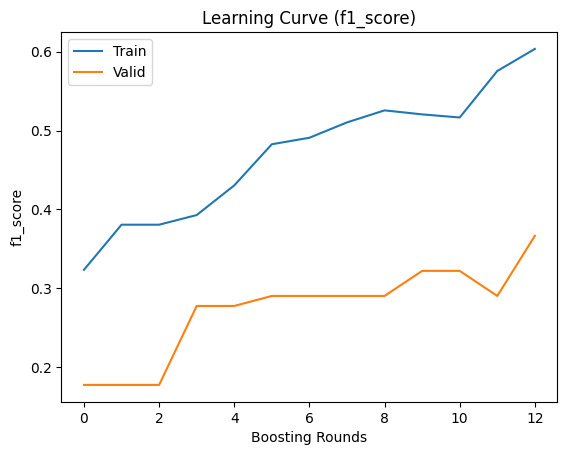


 Total time to Hypertune Model = 3.4774089654286704 minutes


In [58]:
space = {
    'num_boost_round': hp.quniform('num_boost_round', 25, 250, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'num_leaves': hp.quniform('num_leaves', 3, 15, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 3, 15, 1),
    'lambda_l1': hp.loguniform('lambda_l1', np.log(0.01), np.log(2.5)),
    'lambda_l2': hp.loguniform('lambda_l2', np.log(0.01), np.log(2.5)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 0.9),
    'bagging_freq': hp.quniform('bagging_freq', 1, 8, 1),
    'verbose': int(-1)
}

int_cols = relievers.filter(regex="_int_").columns.tolist()

predictors =  int_cols + ['ERA-', 'FIP-', 'K/BB+', 'vote_getter',
                          'AVG+', 'WHIP+', 'K%+', 
                          'SD', 'SD_pct', 'WPA/LI', 'WPA/IP',
                          'WAR', 'WAR/IP', 'decade', 'pos', 'league']

rel_rm = hf.model_and_tune(data=relievers, target_var='rookie_of_the_year', predictors=predictors,
                    space=space, stratify_col='rookie_of_the_year', max_evals=250, stop_rounds=100)

#### Starters

X_train is 323 rows by 34 columns 

X_test is 139 rows by 34 columns 

Number of positive values = 16 

Number of negative values = 446 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	cv_agg's train binary_logloss: 0.0872781 + 0.00520496	cv_agg's train f1_score: 0 + 0	cv_agg's valid binary_logloss: 0.123756 + 0.0330933	cv_agg's valid f1_score: 0 + 0
F1-Score: 0.0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[24]	cv_agg's train binary_logloss: 0.11257 + 0.0120017	cv_agg's train f1_score: 0 + 0	cv_agg's valid binary_logloss: 0.134573 + 0.0288883	cv_agg's valid f1_score: 0 + 0
F1-Score: 0.0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2]	cv_agg's train binary_logloss: 0.114776 + 0.00906272	cv_agg's train f1_score: 0 + 0	cv_agg's valid binary_logloss: 0.138205 + 0.0271116	cv_agg's valid f1_score: 0 + 0
F1-Score: 0.0
Tr

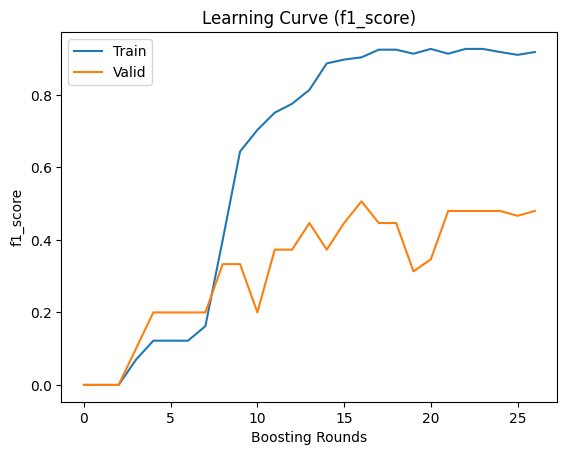


 Total time to Hypertune Model = 3.5923452973365784 minutes


In [59]:
int_cols = starters.filter(regex="_int_").columns.tolist()

predictors = int_cols + ['ERA-', 'FIP-', 'K/BB+', 'HR/9+',
                         'AVG+', 'WHIP+', 'K%+', 'K-BB%', 
                         'WPA/LI', 'WPA/IP',
                         'WAR', 'WAR/IP', 'vote_getter',
                         'decade', 'pos', 'league']

st_rm = hf.model_and_tune(data=starters, target_var='rookie_of_the_year', predictors=predictors,
                    space=space, stratify_col='rookie_of_the_year', max_evals=250, stop_rounds=100)

#### Batters

X_train is 523 rows by 30 columns 

X_test is 225 rows by 30 columns 

Number of positive values = 72 

Number of negative values = 676 

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	cv_agg's train binary_logloss: 0.126661 + 0.00980323	cv_agg's train f1_score: 0.874317 + 0.0275756	cv_agg's valid binary_logloss: 0.219173 + 0.0276637	cv_agg's valid f1_score: 0.554381 + 0.121242
F1-Score: 0.5543812709030101
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	cv_agg's train binary_logloss: 0.204709 + 0.0110456	cv_agg's train f1_score: 0.645178 + 0.035528	cv_agg's valid binary_logloss: 0.242207 + 0.0180027	cv_agg's valid f1_score: 0.482451 + 0.129491
F1-Score: 0.48245098039215684
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	cv_agg's train binary_logloss: 0.103361 + 0.00903753	cv_agg's train f1_score: 0.891167 + 0.05

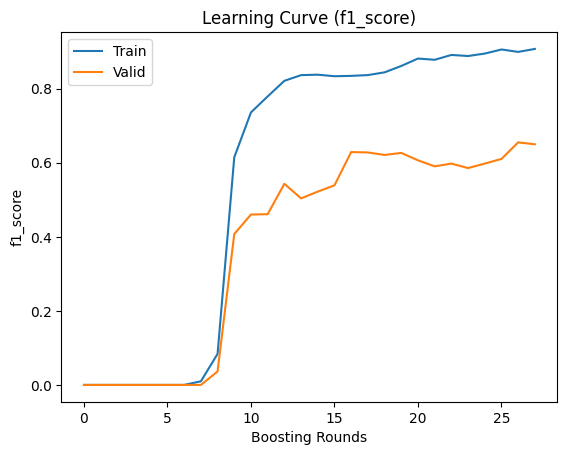


 Total time to Hypertune Model = 4.182135832309723 minutes


In [60]:
int_cols = batters.filter(regex='_int_').columns.tolist()

predictors = int_cols + ['wOBA', 'Off', 'wRC+',
                         'OBP+', 'SLG+',
                         'ISO+', 'WPA/G', 'vote_getter',
                         'WPA/LI', 'WAR', 'WAR/G', 
                         'decade', 'league', 'pos']

bat_rm = hf.model_and_tune(data=batters, target_var='rookie_of_the_year', predictors=predictors,
                    space=space, stratify_col='rookie_of_the_year', max_evals=250, stop_rounds=100)

### Evaluate Model Performance

- Evaluate the model based on the `lgb_test` Dataset

In [61]:
rel_rm_eval = hf.eval_model(model_tuple=rel_rm)
st_rm_eval = hf.eval_model(model_tuple=st_rm)
bat_rm_eval = hf.eval_model(model_tuple=bat_rm)

### Confusion Matrix of Model Validation

In [62]:
rel_rm_cm = hf.conf_mat_model(rel_rm_eval, output_dict=False)
st_rm_cm = hf.conf_mat_model(st_rm_eval, output_dict=False)
bat_rm_cm = hf.conf_mat_model(bat_rm_eval, output_dict=False)

In [63]:
print(rel_rm_cm)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       210
           1       0.00      0.00      0.00         3

    accuracy                           0.96       213
   macro avg       0.49      0.49      0.49       213
weighted avg       0.97      0.96      0.97       213



In [64]:
print(st_rm_cm)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       134
           1       0.67      0.40      0.50         5

    accuracy                           0.97       139
   macro avg       0.82      0.70      0.74       139
weighted avg       0.97      0.97      0.97       139



In [65]:
print(bat_rm_cm)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       203
           1       0.42      0.36      0.39        22

    accuracy                           0.89       225
   macro avg       0.68      0.65      0.66       225
weighted avg       0.88      0.89      0.89       225



## Feature Importance

In [66]:
rel_rm_feat_imp = hf.feat_imp_eval(rel_rm_eval)
st_rm_feat_imp = hf.feat_imp_eval(st_rm_eval)
bat_rm_feat_imp = hf.feat_imp_eval(bat_rm_eval)

In [67]:
print(rel_rm_feat_imp)

                        Feature  Importance  imp_pct
2                    IP_int_K%+     9592.07    46.35
6                HR/9+_int_BB%+     4789.31    23.14
15                SD_int_SD_pct     4260.67    20.59
14                    SD_int_MD      320.55     1.55
20         SD_int_MD_int_SD_pct      241.64     1.17
4                   IP_int_FIP-      194.96     0.94
1                  IP_int_K/BB+      194.51     0.94
28                           SD      189.87     0.92
21                         ERA-      119.67     0.58
16        ERA-_int_FIP-_int_WAR      109.71     0.53
7                  K%+_int_ERA-       92.56     0.45
10               WHIP+_int_FIP-       90.96     0.44
35                          pos       66.00     0.32
32                          WAR       59.83     0.29
25                         AVG+       46.81     0.23
19  ERA-_int_FIP-_int_SD_int_MD       45.35     0.22
24                  vote_getter       42.03     0.20
3                   IP_int_ERA-       36.64   

In [68]:
print(st_rm_feat_imp)

                  Feature  Importance  imp_pct
4              IP_int_K%+     2164.90    35.47
1           ERA-_int_BB%+     1359.53    22.28
17  ERA-_int_FIP-_int_WPA      524.19     8.59
30            vote_getter      373.68     6.12
27                 WPA/IP      281.01     4.60
3            IP_int_K/BB+      273.96     4.49
26                 WPA/LI      216.00     3.54
16  ERA-_int_FIP-_int_WAR      123.53     2.02
14         K-BB%_int_ERA-       97.06     1.59
22                   AVG+       95.47     1.56
6             IP_int_FIP-       86.27     1.41
10           K%+_int_ERA-       85.76     1.41
19                   FIP-       84.86     1.39
18                   ERA-       49.25     0.81
13        WHIP+_int_HR/9+       34.94     0.57
28                    WAR       34.92     0.57
24                    K%+       33.85     0.55
21                  HR/9+       29.36     0.48
12         WHIP+_int_FIP-       28.53     0.47
20                  K/BB+       20.31     0.33
9          HR

In [69]:
print(bat_rm_feat_imp)

                Feature  Importance  imp_pct
2            PA_int_WAR     1547.24    23.23
3           PA_int_wRC+     1467.31    22.03
23          vote_getter      741.24    11.13
6           PA_int_OBP+      442.64     6.65
5           PA_int_BB%+      228.53     3.43
18                 wRC+      214.97     3.23
0           Def_int_Off      210.86     3.17
7          wRC+_int_WAR      202.92     3.05
11         wRC+_int_WPA      183.16     2.75
21                 ISO+      156.96     2.36
24               WPA/LI      151.85     2.28
9         OBP+_int_SLG+      141.94     2.13
17                  Off      135.10     2.03
19                 OBP+      116.97     1.76
14  Def_int_Off_int_WPA      101.91     1.53
13         BB%+_int_K%+       91.99     1.38
4            PA_int_K%+       90.92     1.37
16                 wOBA       76.79     1.15
8          wOBA_int_WAR       72.52     1.09
1         wOBA_int_BB/K       65.54     0.98
20                 SLG+       46.01     0.69
22        

### SHAP Values for Feature Importance

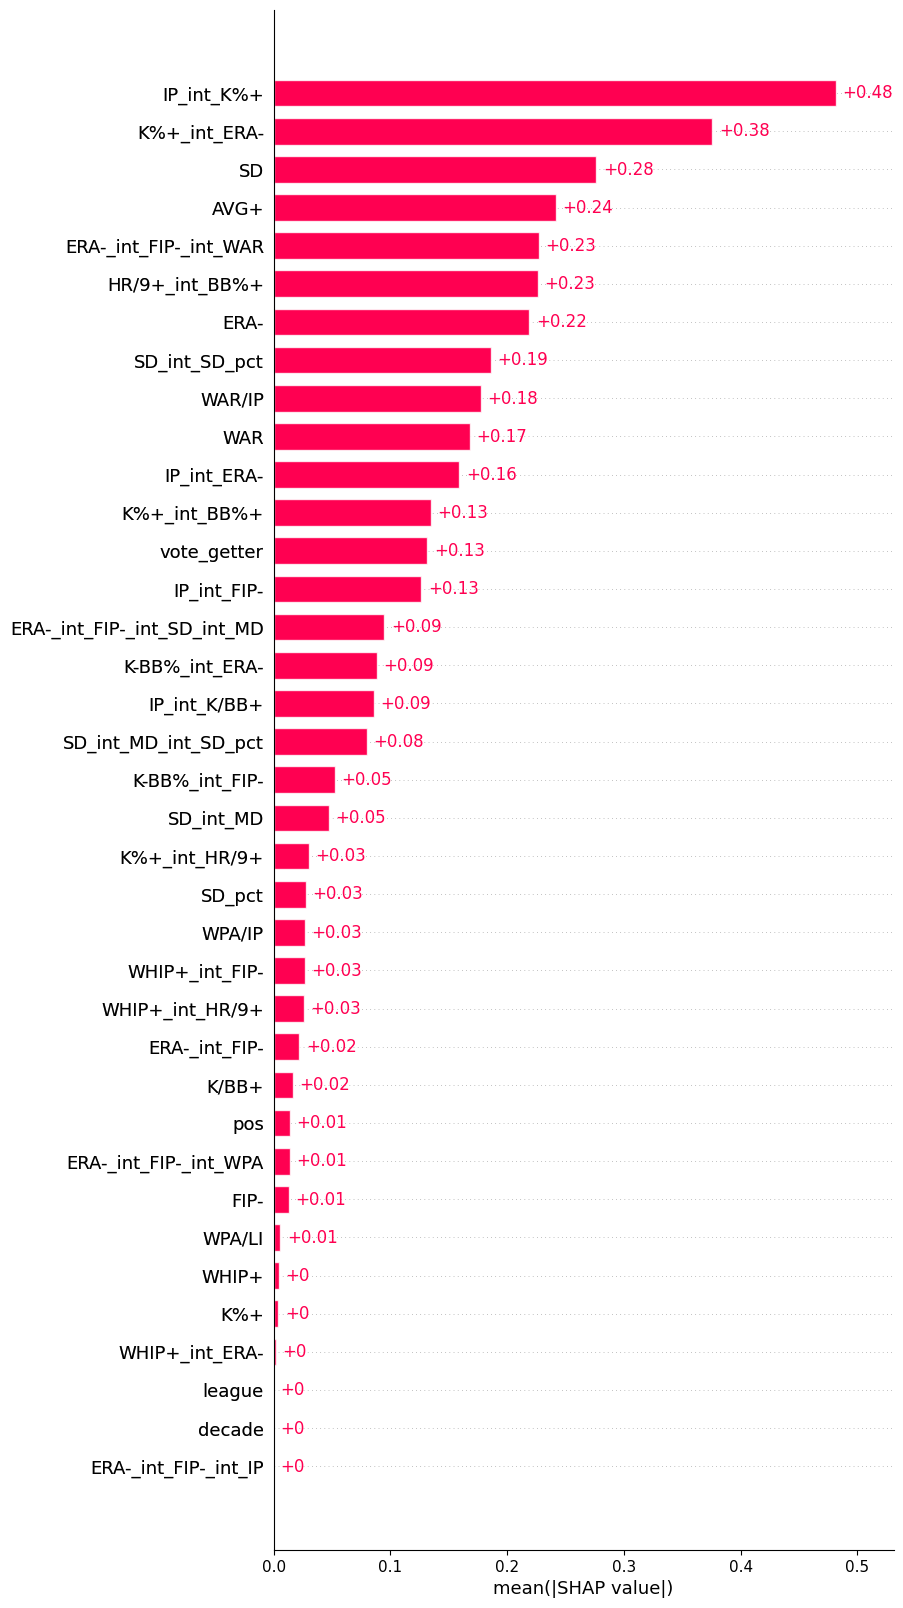

Total Time to Generate Plot: 0.004561320940653483 minutes


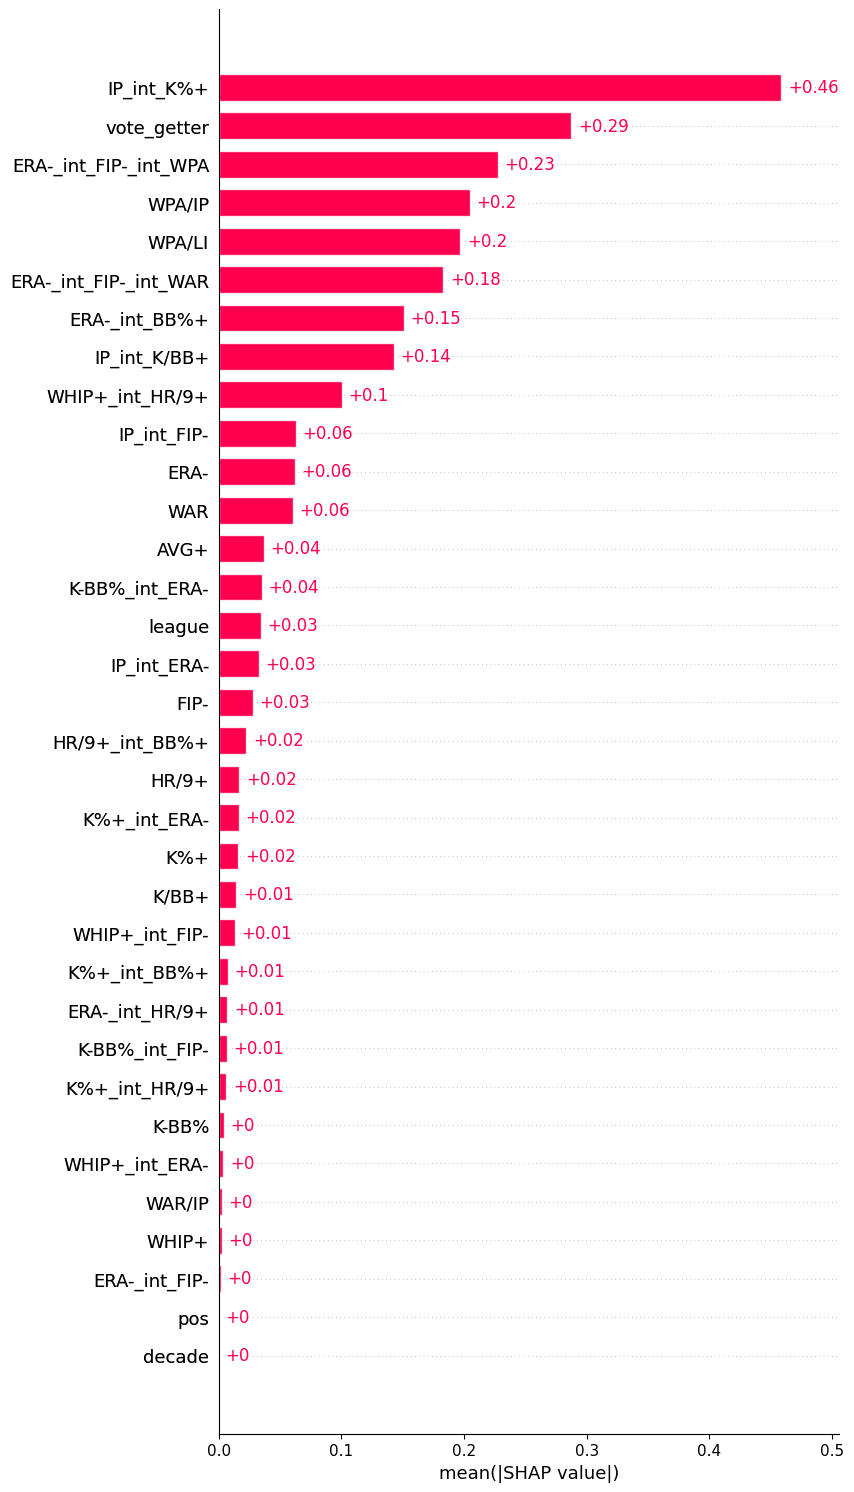

Total Time to Generate Plot: 0.0031901796658833823 minutes


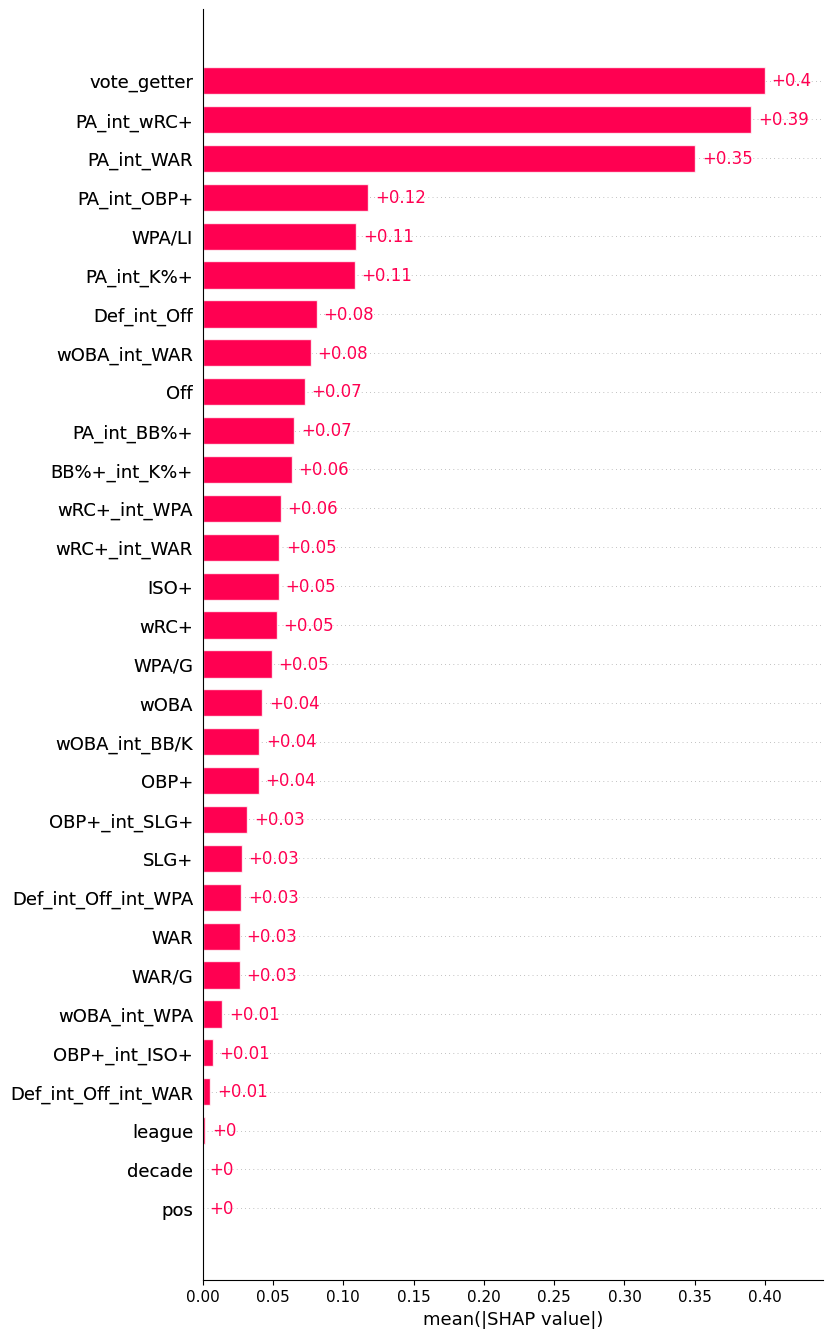

Total Time to Generate Plot: 0.0025293668111165363 minutes


In [70]:
rel_rm_shap_rank = hf.plot_shap_ranks(rel_rm_eval, rel_rm_feat_imp)
st_rm_shap_rank = hf.plot_shap_ranks(st_rm_eval, st_rm_feat_imp)
bat_rm_shap_rank = hf.plot_shap_ranks(bat_rm_eval, bat_rm_feat_imp)

In [72]:
rel_rm_shap_rank

,Feature,mean_shap_value,Importance,imp_pct,imp_Rank,shap_Rank,avg_Rank
0,IP_int_K%+,0.48,9592.07,46.35,1.00,1.00,1.00
1,HR/9+_int_BB%+,0.23,4789.31,23.14,2.00,6.00,4.20
2,SD,0.28,189.87,0.92,8.00,3.00,5.25
3,SD_int_SD_pct,0.19,4260.67,20.59,3.00,8.00,5.75
4,K%+_int_ERA-,0.38,92.56,0.45,11.00,2.00,6.05
5,ERA-_int_FIP-_int_WAR,0.23,109.71,0.53,10.00,5.00,7.25
6,ERA-,0.22,119.67,0.58,9.00,7.00,7.90
7,AVG+,0.24,46.81,0.23,15.00,4.00,8.95
8,IP_int_FIP-,0.13,194.96,0.94,6.00,14.00,10.40
9,WAR,0.17,59.83,0.29,14.00,10.00,11.80


In [73]:
st_rm_shap_rank

,Feature,mean_shap_value,Importance,imp_pct,imp_Rank,shap_Rank,avg_Rank
0,IP_int_K%+,0.46,2164.90,35.47,1.00,1.00,1.00
1,vote_getter,0.29,373.68,6.12,4.00,2.00,2.90
2,ERA-_int_FIP-_int_WPA,0.23,524.19,8.59,3.00,3.00,3.00
3,WPA/IP,0.20,281.01,4.60,5.00,4.00,4.45
4,ERA-_int_BB%+,0.15,1359.53,22.28,2.00,7.00,4.75
5,WPA/LI,0.20,216.00,3.54,7.00,5.00,5.90
6,ERA-_int_FIP-_int_WAR,0.18,123.53,2.02,8.00,6.00,6.90
7,IP_int_K/BB+,0.14,273.96,4.49,6.00,8.00,7.10
8,IP_int_FIP-,0.06,86.27,1.41,11.00,10.00,10.45
9,AVG+,0.04,95.47,1.56,10.00,13.00,11.65


In [74]:
bat_rm_shap_rank

,Feature,mean_shap_value,Importance,imp_pct,imp_Rank,shap_Rank,avg_Rank
0,vote_getter,0.40,741.24,11.13,3.00,1.00,1.90
1,PA_int_wRC+,0.39,1467.31,22.03,2.00,2.00,2.00
2,PA_int_WAR,0.35,1547.24,23.23,1.00,3.00,2.10
3,PA_int_OBP+,0.12,442.64,6.65,4.00,4.00,4.00
4,Def_int_Off,0.08,210.86,3.17,7.00,7.00,7.00
5,WPA/LI,0.11,151.85,2.28,11.00,5.00,7.70
6,PA_int_BB%+,0.07,228.53,3.43,5.00,10.00,7.75
7,wRC+_int_WPA,0.06,183.16,2.75,9.00,12.00,10.65
8,wRC+_int_WAR,0.05,202.92,3.05,8.00,13.00,10.75
9,Off,0.07,135.10,2.03,13.00,9.00,10.80


### Update Model Parameters

In [81]:
rel_rm_eval_x = hf.evaluate_predictors(rank_df=rel_rm_shap_rank, model_tuple=rel_rm, data=relievers, 
                                    stratify_col='rookie_of_the_year', target_var='rookie_of_the_year', 
                                    conf_mat_func=hf.conf_mat_model, 
                                    min_preds=17, max_preds=30)

In [82]:
num_to_remove = rel_rm_eval_x['num_preds_to_remove']
best_rel_preds_rm = rel_rm_shap_rank['Feature'][:-num_to_remove]

up_rm_rel_eval = hf.update_mod_eval(model_tuple=rel_rm, best_predictors = best_rel_preds_rm, data=relievers,
                stratify_col='rookie_of_the_year', target_var='rookie_of_the_year')

In [83]:
st_rm_eval_x = hf.evaluate_predictors(rank_df=st_rm_shap_rank, model_tuple=st_rm, data=starters, 
                                   stratify_col='rookie_of_the_year', target_var='rookie_of_the_year', 
                                   conf_mat_func=hf.conf_mat_model, 
                                   min_preds=14, max_preds=30)

In [84]:
num_to_remove = st_rm_eval_x['num_preds_to_remove']
best_st_preds_rm = st_rm_shap_rank['Feature'][:-num_to_remove]

up_rm_st_eval = hf.update_mod_eval(model_tuple=st_rm, best_predictors = best_st_preds_rm, data=starters,
                stratify_col='rookie_of_the_year', target_var='rookie_of_the_year')

In [124]:
bat_rm_eval_x = hf.evaluate_predictors(rank_df=bat_rm_shap_rank, model_tuple=bat_rm, data=batters, 
                                    stratify_col='rookie_of_the_year', target_var='rookie_of_the_year', 
                                       conf_mat_func=hf.conf_mat_model, 
                                    min_preds=10, max_preds=25)

In [125]:
num_to_remove = bat_rm_eval_x['num_preds_to_remove']
best_bat_preds_rm = bat_rm_shap_rank['Feature'][:-num_to_remove]

up_rm_bat_eval = hf.update_mod_eval(model_tuple=bat_rm, best_predictors = best_bat_preds_rm, 
                              data=batters, stratify_col='rookie_of_the_year', target_var='rookie_of_the_year')

In [126]:
up_conf_mat_rel_rm = hf.conf_mat_model(up_rm_rel_eval, output_dict=False)
up_conf_mat_st_rm = hf.conf_mat_model(up_rm_st_eval, output_dict=False)
up_conf_mat_bat_rm = hf.conf_mat_model(up_rm_bat_eval, output_dict=False)

In [127]:
print(up_conf_mat_rel_rm)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       210
           1       0.00      0.00      0.00         3

    accuracy                           0.97       213
   macro avg       0.49      0.49      0.49       213
weighted avg       0.97      0.97      0.97       213



In [128]:
print(up_conf_mat_st_rm)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       134
           1       0.75      0.60      0.67         5

    accuracy                           0.98       139
   macro avg       0.87      0.80      0.83       139
weighted avg       0.98      0.98      0.98       139



In [129]:
print(up_conf_mat_bat_rm)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       203
           1       0.50      0.50      0.50        22

    accuracy                           0.90       225
   macro avg       0.72      0.72      0.72       225
weighted avg       0.90      0.90      0.90       225



In [130]:
up_rm_rel_feat_imp = hf.feat_imp_eval(up_rm_rel_eval)
up_rm_st_feat_imp = hf.feat_imp_eval(up_rm_st_eval)
up_rm_bat_feat_imp = hf.feat_imp_eval(up_rm_bat_eval)

In [131]:
print(up_rm_rel_feat_imp)

                 Feature  Importance  imp_pct
0             IP_int_K%+     9681.70    46.34
1         HR/9+_int_BB%+     4980.84    23.84
7                   AVG+     3228.40    15.45
5  ERA-_int_FIP-_int_WAR     1260.00     6.03
2                     SD      760.87     3.64
6                   ERA-      279.81     1.34
8            IP_int_FIP-      265.56     1.27
4           K%+_int_ERA-      245.35     1.17
3          SD_int_SD_pct      188.76     0.90


In [132]:
print(up_rm_st_feat_imp)

                  Feature  Importance  imp_pct
0              IP_int_K%+     2254.45    37.24
4           ERA-_int_BB%+     1360.12    22.47
2   ERA-_int_FIP-_int_WPA      689.60    11.39
1             vote_getter      375.61     6.20
3                  WPA/IP      350.62     5.79
7            IP_int_K/BB+      270.09     4.46
5                  WPA/LI      252.93     4.18
6   ERA-_int_FIP-_int_WAR      159.35     2.63
10        WHIP+_int_HR/9+      131.63     2.17
9                    AVG+      121.25     2.00
8             IP_int_FIP-       88.65     1.46


In [133]:
print(up_rm_bat_feat_imp)

          Feature  Importance  imp_pct
1     PA_int_wRC+     1813.57    27.53
2      PA_int_WAR     1265.74    19.22
0     vote_getter      798.39    12.12
3     PA_int_OBP+      383.42     5.82
10           wRC+      345.78     5.25
6     PA_int_BB%+      331.50     5.03
7    wRC+_int_WPA      245.83     3.73
12           ISO+      239.11     3.63
8    wRC+_int_WAR      211.11     3.21
9             Off      187.36     2.84
16           OBP+      153.07     2.32
4     Def_int_Off      150.33     2.28
5          WPA/LI      141.34     2.15
13   wOBA_int_WAR      118.17     1.79
11     PA_int_K%+      117.72     1.79
15  OBP+_int_SLG+       44.27     0.67
14   BB%+_int_K%+       39.70     0.60


In [134]:
relievers_24 = hf.convert_to_cat(relievers_24, cols = ['league', 'pos', 'decade', 'vote_getter'])
starters_24 = hf.convert_to_cat(starters_24, cols = ['league', 'pos', 'decade', 'vote_getter'])
batters_24 = hf.convert_to_cat(batters_24, cols = ['league', 'pos', 'decade', 'vote_getter'])

In [135]:
rm_rel_preds = hf.make_preds(data=relievers_24, predictors=best_rel_preds_rm,
                             eval_tuple=up_rm_rel_eval, target='rookie_of_the_year',
                             round_cols=False)
rm_st_preds = hf.make_preds(data=starters_24, predictors=best_st_preds_rm,
                            eval_tuple=up_rm_st_eval, target='rookie_of_the_year',
                            round_cols=False)
rm_bat_preds = hf.make_preds(data=batters_24, predictors=best_bat_preds_rm,
                             eval_tuple=up_rm_bat_eval, target='rookie_of_the_year',
                             round_cols=False)

In [136]:
combine_cols = ['Name', 'Team', 'league', 'pos', 'rookie_of_the_year']
rm_preds_df = pd.concat([rm_rel_preds[combine_cols].copy(), rm_st_preds[combine_cols].copy(), rm_bat_preds[combine_cols].copy()])
rm_preds_df = rm_preds_df.sort_values('rookie_of_the_year', ascending=False)
rm_preds_df.to_csv('../data/predictions/vote_roy_preds.csv', index=False)
print(rm_preds_df.groupby('league', observed=False).head(8))

               Name Team league      pos  rookie_of_the_year
21       Cade Smith  CLE     AL   relief                0.95
1   Jackson Merrill  SDP     NL       CF                0.71
7        Masyn Winn  STL     NL       SS                0.37
8     Colton Cowser  BAL     AL       LF                0.36
3          Luis Gil  NYY     AL  starter                0.34
4     Michael Busch  CHC     NL       1B                0.31
0   Jackson Chourio  MIL     NL       RF                0.25
0       Paul Skenes  PIT     NL  starter                0.09
1     Shota Imanaga  CHC     NL  starter                0.08
2   Spencer Horwitz  TOR     AL       2B                0.07
6      Tobias Myers  MIL     NL  starter                0.05
13      Jacob Young  WSN     NL       CF                0.05
6      Wilyer Abreu  BOS     AL       RF                0.03
11       Colt Keith  DET     AL       2B                0.02
10   Nolan Schanuel  LAA     AL       1B                0.02
9    Wyatt Langford  TEX

# Let's Talk about the Rookie of the Year

In [137]:
vg_preds_df = pd.read_csv('../data/predictions/vote_preds.csv')
roy_preds_df = pd.read_csv('../data/predictions/vote_roy_preds.csv')
preds_df = pd.merge(vg_preds_df, roy_preds_df,
                    on = ['Name', 'Team', 'league', 'pos'],
                    how='left')
preds_df = preds_df.sort_values('rookie_of_the_year', ascending=False)
print(preds_df.head(10))

               Name Team league      pos  vote_getter  rookie_of_the_year
9        Cade Smith  CLE     AL   relief         0.82                0.95
0   Jackson Merrill  SDP     NL       CF         0.98                0.71
7        Masyn Winn  STL     NL       SS         0.87                0.37
11    Colton Cowser  BAL     AL       LF         0.79                0.36
8          Luis Gil  NYY     AL  starter         0.86                0.34
3     Michael Busch  CHC     NL       1B         0.96                0.31
2   Jackson Chourio  MIL     NL       RF         0.97                0.25
5       Paul Skenes  PIT     NL  starter         0.93                0.09
4     Shota Imanaga  CHC     NL  starter         0.95                0.08
14  Spencer Horwitz  TOR     AL       2B         0.63                0.07


In [138]:
print("The top 8 vote getters for the NL are: \n")
print(preds_df[preds_df['league'] == 'NL'].sort_values('rookie_of_the_year', ascending=False).head(8))

The top 8 vote getters for the NL are: 

               Name Team league      pos  vote_getter  rookie_of_the_year
0   Jackson Merrill  SDP     NL       CF         0.98                0.71
7        Masyn Winn  STL     NL       SS         0.87                0.37
3     Michael Busch  CHC     NL       1B         0.96                0.31
2   Jackson Chourio  MIL     NL       RF         0.97                0.25
5       Paul Skenes  PIT     NL  starter         0.93                0.09
4     Shota Imanaga  CHC     NL  starter         0.95                0.08
23     Tobias Myers  MIL     NL  starter         0.37                0.05
12      Jacob Young  WSN     NL       CF         0.71                0.05


In [139]:
print("The top 8 vote getters for the AL are: \n")
print(preds_df[preds_df['league'] == 'AL'].sort_values('rookie_of_the_year', ascending=False).head(8))

The top 8 vote getters for the AL are: 

               Name Team league      pos  vote_getter  rookie_of_the_year
9        Cade Smith  CLE     AL   relief         0.82                0.95
11    Colton Cowser  BAL     AL       LF         0.79                0.36
8          Luis Gil  NYY     AL  starter         0.86                0.34
14  Spencer Horwitz  TOR     AL       2B         0.63                0.07
13     Wilyer Abreu  BOS     AL       RF         0.71                0.03
22       Colt Keith  DET     AL       2B         0.38                0.02
17   Nolan Schanuel  LAA     AL       1B         0.48                0.02
18   Wyatt Langford  TEX     AL       LF         0.44                0.02


In [140]:
rookie_vote_preds = preds_df.groupby('league').head(8)

## What's going on with Rookies this year?

The Rookie of the Year race is highly contested in baseball this year, specifically with a focus on the National League. The NL has had several high performing rookies including Jackson Merrill, Paul Skenes, and Jackson Chourio. Meanwhile as of today Colton Cowser, and Austin Wells are the favorites in the American League to win Rookie of the Year.

I will be arguing who should be rookie of the year based off of the stats which suggest these players have performed at their highest level this year. For this I will be focusing on "plus" and "minus" statistics, which attempt to neutralize a player's performance based on context. These stats help to account for differing ballparks, and current run environment around the league. 


In [141]:
bat_rank_cols = batters_24.filter(regex='_rank').columns.tolist()
bat_rank_cols.insert(0, 'Name')
bat_rank_cols.insert(1, 'Team')
bat_rank_cols.insert(2, 'league')

In [142]:
batters_24.loc[batters_24['Name'].isin(rookie_vote_preds['Name']), bat_rank_cols]

,Name,Team,league,K%+_rank,wRC+_rank,BB%+_rank,BB/K_rank,OBP+_rank,SLG+_rank,ISO+_rank,...,Def_rank,Off_rank,PA_rank,WPA_rank,WPA/LI_rank,Clutch_rank,mean_rookie_rank,rookie_rank,mean_mlb_rank,mlb_rank
0,Jackson Chourio,MIL,NL,10,4,11,10,7,3,3,...,15,2,7,2,2,4,5.56,1,66.56,32
1,Jackson Merrill,SDP,NL,4,2,20,18,10,1,2,...,11,1,3,1,1,11,5.62,2,69.12,34
2,Spencer Horwitz,TOR,AL,2,1,4,2,1,4,6,...,18,6,20,3,4,2,5.88,3,63.06,29
4,Michael Busch,CHC,NL,21,3,5,8,5,5,4,...,21,3,5,4,3,6,7.44,5,84.12,57
6,Wilyer Abreu,BOS,AL,20,5,10,15,6,2,1,...,10,4,15,9,5,19,8.44,7,94.62,73
7,Masyn Winn,STL,NL,3,10,15,9,14,8,15,...,8,10,1,14,13,15,10.00,8,114.00,111
8,Colton Cowser,BAL,AL,22,6,8,14,8,6,5,...,9,5,8,22,11,22,10.12,9,111.88,108
9,Wyatt Langford,TEX,AL,12,11,9,6,9,13,14,...,19,9,9,6,14,5,10.94,10,117.44,113
10,Nolan Schanuel,LAA,AL,1,9,2,1,2,17,17,...,22,14,2,18,12,20,11.88,11,133.25,131
11,Colt Keith,DET,AL,9,12,14,12,11,14,16,...,12,13,6,12,9,18,12.25,12,137.19,135


In [143]:
print(cli.columnize(bat_rank_cols))

Name      wRC+_rank  SLG+_rank   wOBA_rank  WPA_rank          rookie_rank  
Team      BB%+_rank  ISO+_rank   Def_rank   WPA/LI_rank       mean_mlb_rank
league    BB/K_rank  WAR_rank    Off_rank   Clutch_rank       mlb_rank     
K%+_rank  OBP+_rank  WAR/G_rank  PA_rank    mean_rookie_rank
None


In [144]:
rel_rank_cols = relievers_24.filter(regex='_rank').columns.tolist()
rel_rank_cols.insert(0, 'Name')
rel_rank_cols.insert(1, 'Team')
rel_rank_cols.insert(2, 'league')

In [145]:
relievers_24.loc[relievers_24['Name'].isin(rookie_vote_preds['Name']), rel_rank_cols]

,Name,Team,league,ERA-_rank,FIP-_rank,HR/9+_rank,WHIP+_rank,AVG+_rank,BB%+_rank,MD_rank,...,WPA/LI_rank,K/BB+_rank,K-BB%_rank,SD_rank,SD_pct_rank,Clutch_rank,mean_rookie_rank,rookie_rank,mlb_rank,mean_mlb_rank
21,Cade Smith,CLE,AL,3,1,1,4,6,6,8,...,2,2,2,2,3,8,3.11,1,2,13.67


In [146]:
print(cli.columnize(rel_rank_cols))

Name       HR/9+_rank  WAR_rank     WPA/LI_rank  Clutch_rank     
Team       WHIP+_rank  WAR/IP_rank  K/BB+_rank   mean_rookie_rank
league     AVG+_rank   IP_rank      K-BB%_rank   rookie_rank     
ERA-_rank  BB%+_rank   K%+_rank     SD_rank      mlb_rank        
FIP-_rank  MD_rank     WPA_rank     SD_pct_rank  mean_mlb_rank   
None


In [147]:
st_rank_cols = starters_24.filter(regex='_rank').columns.tolist()
st_rank_cols.insert(0, 'Name')
st_rank_cols.insert(1, 'Team')
st_rank_cols.insert(2, 'league')

In [148]:
starters_24.loc[starters_24['Name'].isin(rookie_vote_preds['Name']), st_rank_cols]

,Name,Team,league,ERA-_rank,FIP-_rank,HR/9+_rank,WHIP+_rank,AVG+_rank,BB%+_rank,WAR_rank,...,WPA_rank,WPA/LI_rank,K/BB+_rank,K-BB%_rank,Clutch_rank,QS_rank,mean_rookie_rank,rookie_rank,mlb_rank,mean_mlb_rank
0,Paul Skenes,PIT,NL,1,1,1,1,2,7,1,...,1,1,3,1,3,2,2.12,1,4,15.44
1,Shota Imanaga,CHC,NL,3,5,14,2,3,1,2,...,3,2,1,3,12,1,4.00,2,17,29.06
3,Luis Gil,NYY,AL,4,3,2,6,1,14,3,...,2,3,13,7,6,5,4.94,3,37,42.31
6,Tobias Myers,MIL,NL,2,9,10,5,7,5,9,...,6,5,6,6,7,11,7.06,8,55,53.75


In [149]:
print(cli.columnize(st_rank_cols))

Name       FIP-_rank   BB%+_rank    K%+_rank     K-BB%_rank        rookie_rank  
Team       HR/9+_rank  WAR_rank     WPA_rank     Clutch_rank       mlb_rank     
league     WHIP+_rank  WAR/IP_rank  WPA/LI_rank  QS_rank           mean_mlb_rank
ERA-_rank  AVG+_rank   IP_rank      K/BB+_rank   mean_rookie_rank
None


## Explaining the `_rank` variables

The variables which end in rank excluding those containing `rookie_rank` or `mlb_rank` were calculated as the percentile ranking within their rookie class, and position grouping (Starters, Relievers, or Batters). For example, Paul Skenes having an `ERA-_rank` of 1.00 indicates Paul Skenes is in the 100th percentile amongst 2024 Rookie Starters for `ERA-`. This indicates he has the lowest `ERA-` of all starting pitchers.

The reason I created these rankings within the positional groupings is because of the fact the variables used for Relievers is differen than those for Starters. Aside from that both of the pitchers variables are different from those used for the Batters.

Nonetheless I will talk about their impact as a whole within the data (including from an MLB standpoint). Those variables containing containing `mean_rookie_rank` or `mean_mlb_rank` are the average percentiles of all the corresponding `_rank` variables. The `rookie_rank` and `mlb_rank` are integer values indicating their absolute rank based off the `mean_` rank variables within the Rookie class or MLB class for that season. 

    For example Shota Imanaga has an `mlb_rank` of 13 which means he has been the 13th best starting pitcher during the 2024 season ranking wise within the MLB.

## Examining the Ranks of our Vote Getters

### Relievers

In [150]:
relievers_cols = ['Name', 'Team', 'league', 'IP_rank', 'ERA-_rank', 'FIP-_rank',
                 'HR/9+_rank', 'WHIP+_rank', 'WAR_rank', 'SD_rank', 'MD_rank', 'SD_pct_rank',
                 'WAR/IP_rank', 'K%+_rank', 'WPA_rank', 'WPA/LI_rank', 
                 'K/BB+_rank', 'Clutch_rank', 
                 'rookie_rank', 'mlb_rank']

In [151]:
# Set the number of decimals to 2
pd.options.display.float_format = '{:.2f}'.format
relievers_24.loc[relievers_24['Name'].isin(rookie_vote_preds['Name']), relievers_cols]

,Name,Team,league,IP_rank,ERA-_rank,FIP-_rank,HR/9+_rank,WHIP+_rank,WAR_rank,SD_rank,MD_rank,SD_pct_rank,WAR/IP_rank,K%+_rank,WPA_rank,WPA/LI_rank,K/BB+_rank,Clutch_rank,rookie_rank,mlb_rank
21,Cade Smith,CLE,AL,1,3,1,1,4,1,2,8,3,2,2,2,2,2,8,1,2


#### Who has been the best?

**Cade Smith (Cleveland Guardians)**

Cade Smith remains the strongest candidate for Rookie of the Year among relief pitchers. Smith demonstrates incredible overall performance, with an impressive rookie rank of 1 and an MLB rank of 3, highlighting his excellence both among rookies and across the league. He excels in key pitching metrics such as ERA- (0.91), WHIP+ (0.86), and WAR (1.00 - best in the league), showing a well-rounded ability to dominate on the mound. His high IP rank (1.00 - most in the league) indicates that he consistently performs across many innings, a crucial factor for maintaining reliability throughout the season. His consistency across important categories, including FIP- (1.00 - best in the league), HR/9+ (1.00 - best in the league), and K/BB+ (0.95), suggests that he effectively limits home runs, strikes out more batters than he walks, and maintains control over the game while on the mound. Cade Smith has truly shown the makings of a standout rookie pitcher with hall-of-fame potential, even though Cooperstown and Rookie of the Year voters tend to overlook relief pitchers.

**Mason Miller (Oakland Athletics)**

Mason Miller, with a rookie rank of 2 and an MLB rank of 5, also shows promise, particularly with his WAR/IP (1.00 - best in league) and K%+ (1.00 - best in league), but he trails Smith in several other key metrics, such as ERA- (0.77) and K/BB+ (0.86), keeping him behind Smith in overall performance. Miller’s slightly lower IP rank (0.59 - due to him being a closer) indicates that he hasn’t logged as many innings as Smith, which may impact his candidacy for Rookie of the Year. However one can never expect a closer to really log the same amount of innings as an ordinary reliever.

Interestingly, the three pitchers with legitimate chances at winning Rookie of the Year are all from the American League, and two of them—Smith and Gaddis—are from the same team, the Cleveland Guardians. Gaddis, with a rookie rank of 3 and an MLB rank of 9, also boasts strong numbers, including a reliever leading ERA- (1.00), but overall he's a step behind both Smith and Miller.

What's intriguing is that the model predicts Mason Miller to have the highest probability among relievers for winning Rookie of the Year, despite Smith being the top performer in most categories. This could be due to a potential bias in the model toward closing pitchers, with Miller benefiting from his positional role in the model’s predictions. Additionally, despite Smith’s superior overall performance, he has the lowest odds of winning Rookie of the Year among the three, which could be a reflection of this positional bias.

**The Reliever Rookie of the Year**

Overall, Cade Smith’s consistent excellence throughout the season, particularly his performance across multiple key metrics, makes him the clear choice for Rookie of the Year among these pitchers.

### Starters

In [152]:
starters_cols = ['Name', 'Team', 'league', 'ERA-_rank', 'FIP-_rank',
                 'HR/9+_rank', 'WHIP+_rank', 'WAR_rank', 'AVG+_rank', 'IP_rank',
                 'WAR/IP_rank', 'K%+_rank', 'WPA_rank', 'WPA/LI_rank', 
                 'K/BB+_rank', 'Clutch_rank', 'QS_rank',
                 'rookie_rank', 'mlb_rank']

In [153]:
# Set the number of decimals to 2
pd.options.display.float_format = '{:.2f}'.format
starters_24.loc[starters_24['Name'].isin(rookie_vote_preds['Name']), starters_cols]

,Name,Team,league,ERA-_rank,FIP-_rank,HR/9+_rank,WHIP+_rank,WAR_rank,AVG+_rank,IP_rank,WAR/IP_rank,K%+_rank,WPA_rank,WPA/LI_rank,K/BB+_rank,Clutch_rank,QS_rank,rookie_rank,mlb_rank
0,Paul Skenes,PIT,NL,1,1,1,1,1,2,7,1,1,1,1,3,3,2,1,4
1,Shota Imanaga,CHC,NL,3,5,14,2,2,3,1,5,6,3,2,1,12,1,2,17
3,Luis Gil,NYY,AL,4,3,2,6,3,1,5,3,2,2,3,13,6,5,3,37
6,Tobias Myers,MIL,NL,2,9,10,5,9,7,8,9,8,6,5,6,7,11,8,55


#### Who has been the best?

**Paul Skenes (Pittsburgh Pirates)**

Paul Skenes is the clear standout candidate for Rookie of the Year among the four starting pitchers (predicted to receive votes). He ranks 1st in the rookie category and 4th in the MLB, showcasing his dominance among both rookies and across the league. His performance metrics are outstanding, with a perfect 1.00 rank in key categories such as ERA-, FIP-, HR/9+, WHIP+, WAR, K%+, and WPA. This demonstrates his all-around effectiveness in run prevention, strikeouts, and overall contribution to team success. His high WAR/IP rank (1.00) and strong control (K/BB+ rank of 1.00) further solidify his case as the top rookie, making him one of the most well-rounded pitchers in his rookie class.

Imanaga’s overall performance is great. However, Skenes' rapid ascent to the MLB and dominance in nearly every category makes his rookie season even more impressive. At just 22 years old and within a year of being drafted, Skenes has already established himself as a dominant pitcher in the league. Meanwhile Imanaga has had 8 year of NPB experience prior to his MLB rookie season..

Overall, Paul Skenes’ consistency and excellence across all major categories make him the clear choice for Rookie of the Year among these starting pitchers. His youth, rapid development, and nearly flawless performance metrics place him far ahead of his peers.

### Batters

In [154]:
batter_cols = ['Name', 'Team', 'league', 'wRC+_rank', 'OBP+_rank',
               'SLG+_rank', 'ISO+_rank', 'WAR_rank', 'WAR/G_rank', 
               'wOBA_rank', 'Def_rank', 'WPA_rank', 'WPA/LI_rank',
               'Clutch_rank', 'rookie_rank', 'mlb_rank']

In [155]:
# Set the number of decimals to 2
batters_24.loc[batters_24['Name'].isin(rookie_vote_preds['Name']), batter_cols]

,Name,Team,league,wRC+_rank,OBP+_rank,SLG+_rank,ISO+_rank,WAR_rank,WAR/G_rank,wOBA_rank,Def_rank,WPA_rank,WPA/LI_rank,Clutch_rank,rookie_rank,mlb_rank
0,Jackson Chourio,MIL,NL,4,7,3,3,2,3,4,15,2,2,4,1,32
1,Jackson Merrill,SDP,NL,2,10,1,2,1,2,2,11,1,1,11,2,34
2,Spencer Horwitz,TOR,AL,1,1,4,6,12,8,1,18,3,4,2,3,29
4,Michael Busch,CHC,NL,3,5,5,4,10,11,5,21,4,3,6,5,57
6,Wilyer Abreu,BOS,AL,5,6,2,1,7,4,3,10,9,5,19,7,73
7,Masyn Winn,STL,NL,10,14,8,15,6,9,10,8,14,13,15,8,111
8,Colton Cowser,BAL,AL,6,8,6,5,4,5,7,9,22,11,22,9,108
9,Wyatt Langford,TEX,AL,11,9,13,14,14,14,11,19,6,14,5,10,113
10,Nolan Schanuel,LAA,AL,9,2,17,17,22,22,9,22,18,12,20,11,131
11,Colt Keith,DET,AL,12,11,14,16,11,15,12,12,12,9,18,12,135


## What does the Model say about Rookie of the Year?

In [156]:
preds_df[(preds_df['rookie_of_the_year'] > 0.005)].\
sort_values('rookie_of_the_year', ascending=False)

,Name,Team,league,pos,vote_getter,rookie_of_the_year
9,Cade Smith,CLE,AL,relief,0.82,0.95
0,Jackson Merrill,SDP,NL,CF,0.98,0.71
7,Masyn Winn,STL,NL,SS,0.87,0.37
11,Colton Cowser,BAL,AL,LF,0.79,0.36
8,Luis Gil,NYY,AL,starter,0.86,0.34
3,Michael Busch,CHC,NL,1B,0.96,0.31
2,Jackson Chourio,MIL,NL,RF,0.97,0.25
5,Paul Skenes,PIT,NL,starter,0.93,0.09
4,Shota Imanaga,CHC,NL,starter,0.95,0.08
14,Spencer Horwitz,TOR,AL,2B,0.63,0.07


### National League

As of September 17th, 2024 at 1:45pm the betting odds for NL Rookie of the Year are as follows

<table>
  <tr>
    <th style="font-size:16px">Player Name</th>
    <th style="font-size:16px">MGM</th>
    <th style="font-size:16px">ESPN BET</th>
    <th style="font-size:16px">Caesar's</th>
    <th style="font-size:16px">Draft Kings</th>
    <th style="font-size:16px">FanDuel</th>
    <th style="font-size:16px">Average Odds</th>
  </tr>
  <tr>
    <td style="font-size:16px">Jackson Merrill</td>
    <td style="font-size:16px">-500</td>
    <td style="font-size:16px">-425</td>
    <td style="font-size:16px">-625</td>
    <td style="font-size:16px">-600</td>
    <td style="font-size:16px">-340</td>
    <td style="font-size:16px">-498</td>
  </tr>
  <tr>
    <td style="font-size:16px">Paul Skenes</td>
    <td style="font-size:16px">+225</td>
    <td style="font-size:16px">+260</td>
    <td style="font-size:16px">+220</td>
    <td style="font-size:16px">+280</td>
    <td style="font-size:16px">+220</td>
    <td style="font-size:16px">+241</td>
  </tr>
  <tr>
    <td style="font-size:16px">Jackson Chourio</td>
    <td style="font-size:16px">+3000</td>
    <td style="font-size:16px">+3300</td>
    <td style="font-size:16px">+2200</td>
    <td style="font-size:16px">+3000</td>
    <td style="font-size:16px">+4000</td>
    <td style="font-size:16px">+3100</td>
  </tr>
</table>

The model for vote getters did a great job. The model correctly identified the top 3 vote getters would receive votes (which it looks like they all will), and they had the 3 highest probabilities for receiving a vote.

The model for predicting the Rookie of the Year seemed to do a good job at getting the 2 batters correct, as it predicts that either Merrill or Chourio will be NL Rookie of the Year.

Again, I don't agree with the betting odds they simply don't make sense. Paul Skenes is having a top 10 rookie pitching campaign since 1974 while Jackson Merrill is having maybe a top 50 rookie hitting campaign. It does not make sense why the odds favor Merrill other than the explanation of there being a prominently existing positional bias for hitters over pitchers in Rookie of the Year voting.

Skenes should be Rookie of the Year in the NL.

### American League

As of September 17th, 2024 at 1:45pm the betting odds for AL Rookie of the Year are as follows:

<table>
  <tr>
    <th style="font-size:16px">Player Name</th>
    <th style="font-size:16px">MGM</th>
    <th style="font-size:16px">ESPN BET</th>
    <th style="font-size:16px">Caesar's</th>
    <th style="font-size:16px">Draft Kings</th>
    <th style="font-size:16px">FanDuel</th>
    <th style="font-size:16px">Average Odds</th>
  </tr>
  <tr>
    <td style="font-size:16px">Luis Gil</td>
    <td style="font-size:16px">+110</td>
    <td style="font-size:16px">+135</td>
    <td style="font-size:16px">+100</td>
    <td style="font-size:16px">+110</td>
    <td style="font-size:16px">+120</td>
    <td style="font-size:16px">+115</td>
  </tr>
  <tr>
    <td style="font-size:16px">Austin Wells</td>
    <td style="font-size:16px">+150</td>
    <td style="font-size:16px">+145</td>
    <td style="font-size:16px">+125</td>
    <td style="font-size:16px">+160</td>
    <td style="font-size:16px">+175</td>
    <td style="font-size:16px">+151</td>
  </tr>
  <tr>
    <td style="font-size:16px">Colton Cowser</td>
    <td style="font-size:16px">+225</td>
    <td style="font-size:16px">+225</td>
    <td style="font-size:16px">+220</td>
    <td style="font-size:16px">+230</td>
    <td style="font-size:16px">+210</td>
    <td style="font-size:16px">+222</td>
  </tr>
</table>

Interestingly the AL Rookie of the Year model did poorly when predicting the betting favorite. Mason Miller, Cade Smith, Colton Cowser, and Wilyer Abreu were the favorites of the model. Miller, Smith, and Abreu are not top 4 on any platform for betting odds to win AL Rookie of the Year. This could suggest potential positional bias, which likely exists, especially since Miller and Smith are closer and relief pitchers respectively. However I will talk about the odds presented above to keep relevance.

The AL Rookie of the Year race has been more interesting as of recently. Up until earlier this week, Colton Cowser had been the favorite to win AL Rookie of the Year. However Austin Wells has been on a tear since the All-Star break and has slowly been creeping up the ladder until finally overtaking Cowser this week. As of yesterday, Luis Gil shot up the ranks from being a severe 3rd underdog to now being the favorite on some betting platforms.

I personally think Austin Wells should win the AL Rookie of the Year over Cowser. Wells has done pretty much everything better than Cowser, but I wouldn't be shocked if Cowser won the award. Cowser has played 35-40 more games than Austin Wells, so it would make sense because he's proven he can play well consistently and for large amounts of games.

I want to draw attention to the fact that Austin Wells was not featured in the Rookie of the Year model results. Again I think these model results points towards simple positional bias yet again. Catchers rarely are ever chosen as Rookie of the Year (only 3 times since 1974), so I think it's clear as to why Wells is not a favorite of the model.

In [157]:
batters.to_csv('../data/cleaned/bat_model_train.csv')
relievers.to_csv('../data/cleaned/relief_model_train.csv')
starters.to_csv('../data/cleaned/starter_model_train.csv')

batters_24.to_csv('../data/cleaned/bat_24_model_train.csv')
relievers_24.to_csv('../data/cleaned/relief_24_model_train.csv')
starters_24.to_csv('../data/cleaned/starter_24_model_train.csv')